# Crime Rate Prediction

Programmazione di Applicazioni Data Intensive
Laurea in Ingegneria e Scienze Informatiche
DISI - Università di Bologna, Cesena

Lorenzo Tordi

Margherita Raponi


# Descrizione del problema

Il nostro obiettivo è quello di creare un modello di regressione in grado di predire il numero di certe categorie di crimini, conoscendo i seguenti fattori:

*  Nazione
*  Popolazione della nazione
*  Tasso di occupazione
*  Inflazione
*  Personale di polizia per nazione


I crimini che vogliamo predirre sono:


*   Furto
*   Omicidio
*   Rapimento
*   Violenza sessuale



Cercando online, siamo riusciti a trovare i dataset necessari. I dataset sono stati presi dal sito online della UNODC (United Nations Office on Drugs and Crime) e dal sito della WBG (World Bank Group).

# Descrizione dei dati

I dataset considerati sono 7:


*   `theftCrime`, che contiene i dati relativi al numero di furti.
*   `homicideCrime`, che contiene i dati relativi al numero di omicidi.
*   `violent_sexualCrime`, che contiene i dati relativi al numero di casi di violenza sessuale e di rapimenti.
*   `employment`, che contiene i dati relativi al tasso di occupazione.
*   `inflation`, che contiene i dati relativi all'inflazione.
*   `police_personnel`, che contiene i dati relativi al personale di polizia.
*   `population`, che contiene i dati relativi alla popolazione.



## Caricamento Librerie
Per prima cosa carichiamo le librerie per effettuare operazioni sui dati

*   NumPy per creare e operare su array a N dimensioni
*   pandas per caricare e manipolare dati tabulari
*   matplotlib per creare grafici

Importiamo le librerie usando i loro alias convenzionali

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Furto

In [27]:
import os.path
file = "data_cts_corruption_and_economic_crime.csv"
if not os.path.exists(file):
    print("Missing dataset")
else:
  theftCrime = pd.read_csv(file, index_col=False, encoding='latin1')

In [28]:
theftCrime.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22754 entries, 0 to 22753
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Iso3_code            22754 non-null  object 
 1   Country              22754 non-null  object 
 2   Region               22754 non-null  object 
 3   Subregion            22754 non-null  object 
 4   Indicator            22754 non-null  object 
 5   Dimension            22754 non-null  object 
 6   Category             22754 non-null  object 
 7   Sex                  22754 non-null  object 
 8   Age                  22754 non-null  object 
 9   Year                 22754 non-null  int64  
 10  Unit of measurement  22754 non-null  object 
 11  VALUE                22754 non-null  float64
 12  Source               22754 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 16.5 MB


In [29]:
theftCrime.shape

(22754, 13)

In [30]:
theftCrime.head()

,Iso3_code,Country,Region,Subregion,Indicator,Dimension,Category,Sex,Age,Year,Unit of measurement,VALUE,Source
0,ARM,Armenia,Asia,Western Asia,Offences,by type of offence,Corruption,Total,Total,2013,Counts,782.0,CTS
1,AUT,Austria,Europe,Western Europe,Offences,by type of offence,Corruption,Total,Total,2013,Counts,3439.0,CTS
2,CHE,Switzerland,Europe,Western Europe,Offences,by type of offence,Corruption,Total,Total,2013,Counts,4884.0,CTS
3,CHL,Chile,Americas,Latin America and the Caribbean,Offences,by type of offence,Corruption,Total,Total,2013,Counts,339.0,CTS
4,COL,Colombia,Americas,Latin America and the Caribbean,Offences,by type of offence,Corruption,Total,Total,2013,Counts,23483.0,CTS


Come possiamo vedere, il dataset ha 13 feature:

* `Iso3_code`: codice ISO a 3 lettere del paese.
* `Country`:nome del paese.
* `Region`: la regione geografica in cui si trova il paese.
* `Subregion`: la sottoregione geografica in cui si trova il paese.
* `Indicator`: indica il tipo di dato riportato.
* `Dimension`: descrive la dimensione specifica del dato.
* `Category`: la categoria specifica del reato.
* `Sex`: il genere delle persone coinvolte.
* `Age`: l'età delle persone coinvolte.
* `Year`: l'anno in cui il dato è stato raccolto.
* `Unit of measurement`: l'unità di misura utilizzata per il valore riportato.
* `VALUE`: il valore numerico del dato.
* `Source`: la fonte del dato.

### Preprocessing dei dati
Filtriamo il dataframe utilizzando come unità solo `Counts` inevce che `Rate per 100,000 population`. Effettuiamo quindi una prima scrematura dei dati.

Selezioniamo inoltre soltanto le categorie d'interesse, ovvero nel nostro caso `Theft` e `Burglary`.

In [31]:
theftCrime = theftCrime[theftCrime['Unit of measurement'] != "Rate per 100,000 population"]
theftCrime = theftCrime[theftCrime['Category'].isin(['Theft', 'Burglary'])]

In [32]:
theftCrime.shape

(3563, 13)

Analizzando il dataframe, le feature `Age`, `Sex`, `Dimension`, `Unit of measurement`e `Source` non sono rilevanti per il nostro modello, perciò le rimoviamo.

In [33]:
theftCrime = theftCrime.drop(['Unit of measurement', 'Sex', 'Age', 'Source', 'Dimension', 'Indicator'], axis=1)

In [34]:
theftCrime.head()

,Iso3_code,Country,Region,Subregion,Category,Year,VALUE
2486,ARE,United Arab Emirates,Asia,Western Asia,Burglary,2003,1882.0
2487,AUS,Australia,Oceania,Australia and New Zealand,Burglary,2003,354020.0
2488,AZE,Azerbaijan,Asia,Western Asia,Burglary,2003,757.0
2489,BEL,Belgium,Europe,Western Europe,Burglary,2003,97007.0
2490,BGR,Bulgaria,Europe,Eastern Europe,Burglary,2003,28210.0


Dalle informazioni ottenute nel paragrafo precedente notiamo che la maggior parte delle feature tranne `Year` e `Value` sono di tipo `Object`, questo perchè paython converte automaticamente in tipo objet tutti i dati che non sono interi. Dunque cambiamo i vari tipi delle feature.

Inoltre, rimuoviamo, se vi sono, le varie righe conteneti valori nulli e rinominiamo la colonna `Iso3_code` in `Country Code`.

In [35]:
theftCrime["Country"] = theftCrime["Country"].astype(pd.StringDtype())
theftCrime["Region"] = theftCrime["Region"].astype(pd.StringDtype())
theftCrime["Subregion"] = theftCrime["Subregion"].astype(pd.StringDtype())
theftCrime["Category"] = theftCrime["Category"].astype(pd.StringDtype())
theftCrime["Iso3_code"] = theftCrime["Iso3_code"].astype(pd.StringDtype())

theftCrime.rename(columns={'Iso3_code':'Country Code'}, inplace=True)

theftCrime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3563 entries, 2486 to 6048
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  3563 non-null   string 
 1   Country       3563 non-null   string 
 2   Region        3563 non-null   string 
 3   Subregion     3563 non-null   string 
 4   Category      3563 non-null   string 
 5   Year          3563 non-null   int64  
 6   VALUE         3563 non-null   float64
dtypes: float64(1), int64(1), string(5)
memory usage: 222.7 KB


In [36]:
theftCrime.dropna()
theftCrime.shape

(3563, 7)

Notiamo che il nostro dataset non contiene valori nulli in quanto la shape non è cambiata.

Infine, dovendo analizzare due crimini differenti, separiamo le due casitiche e rinominamo la colonna `VALUE` in `theft_count` e `burglary_count`.

Avendo lasciato nel dataframe solo una tipologia di categoria, possiamo eliminare la colonna `Category` in quanto è ridondante.

In [37]:
theft = theftCrime.copy()
theft = theft[theft['Category'].isin(['Theft'])]
theft = theft.drop(['Category'], axis=1)
print(theft.shape)
theft.head()

(1904, 6)


,Country Code,Country,Region,Subregion,Year,VALUE
4145,ARE,United Arab Emirates,Asia,Western Asia,2003,10802.0
4146,ARM,Armenia,Asia,Western Asia,2003,2831.0
4147,AUS,Australia,Oceania,Australia and New Zealand,2003,624036.0
4148,AZE,Azerbaijan,Asia,Western Asia,2003,1820.0
4149,BEL,Belgium,Europe,Western Europe,2003,225000.0


In [38]:
burglary = theftCrime.copy()
burglary = burglary[burglary['Category'].isin(['Burglary'])]
burglary = burglary.drop(['Category'], axis=1)
print(burglary.shape)
burglary.head()

(1659, 6)


,Country Code,Country,Region,Subregion,Year,VALUE
2486,ARE,United Arab Emirates,Asia,Western Asia,2003,1882.0
2487,AUS,Australia,Oceania,Australia and New Zealand,2003,354020.0
2488,AZE,Azerbaijan,Asia,Western Asia,2003,757.0
2489,BEL,Belgium,Europe,Western Europe,2003,97007.0
2490,BGR,Bulgaria,Europe,Eastern Europe,2003,28210.0


In [39]:
theft.rename(columns={'VALUE':'theft_count'}, inplace=True)
burglary.rename(columns={'VALUE':'burglary_count'}, inplace=True)

In [40]:
theft.describe()

,Year,theft_count
count,1904.000000,1.904000e+03
mean,2012.284139,2.041721e+05
std,5.507616,6.686822e+05
min,2003.000000,0.000000e+00
25%,2008.000000,5.014500e+03
50%,2012.000000,2.516400e+04
75%,2017.000000,1.247930e+05
max,2022.000000,7.026802e+06


In [41]:
burglary.describe()

,Year,burglary_count
count,1659.000000,1.659000e+03
mean,2012.474382,7.028198e+04
std,5.468942,2.145695e+05
min,2003.000000,0.000000e+00
25%,2008.000000,1.513000e+03
50%,2012.000000,9.703000e+03
75%,2017.000000,5.444000e+04
max,2022.000000,2.228887e+06


Contiamo anche il numero di paesi nei nostri due dataframe.

In [42]:
print(f"Numero totale di paesi in theft: {theft['Country'].unique().size}")
print(f"Numero totale di paesi in burglary: {burglary['Country'].unique().size}")

Numero totale di paesi in theft: 146
Numero totale di paesi in burglary: 138


## Crimini per omicidio

In [43]:
file = "data_cts_intentional_homicide.csv"
if not os.path.exists(file):
    print("Missing dataset")
else:
  homicideCrime = pd.read_csv(file, index_col=False, encoding='latin1')

In [44]:
homicideCrime.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117070 entries, 0 to 117069
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Iso3_code            117070 non-null  object 
 1   Country              117070 non-null  object 
 2   Region               117070 non-null  object 
 3   Subregion            117070 non-null  object 
 4   Indicator            117070 non-null  object 
 5   Dimension            117070 non-null  object 
 6   Category             117070 non-null  object 
 7   Sex                  117070 non-null  object 
 8   Age                  117070 non-null  object 
 9   Year                 117070 non-null  int64  
 10  Unit of measurement  117070 non-null  object 
 11  VALUE                117070 non-null  float64
 12  Source               117070 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 87.4 MB


In [45]:
homicideCrime.shape

(117070, 13)

In [46]:
homicideCrime.head()

,Iso3_code,Country,Region,Subregion,Indicator,Dimension,Category,Sex,Age,Year,Unit of measurement,VALUE,Source
0,ARM,Armenia,Asia,Western Asia,Persons arrested/suspected for intentional hom...,by citizenship,National citizens,Male,Total,2013,Counts,35.0,CTS
1,CHE,Switzerland,Europe,Western Europe,Persons arrested/suspected for intentional hom...,by citizenship,National citizens,Male,Total,2013,Counts,28.0,CTS
2,COL,Colombia,Americas,Latin America and the Caribbean,Persons arrested/suspected for intentional hom...,by citizenship,National citizens,Male,Total,2013,Counts,15053.0,CTS
3,CZE,Czechia,Europe,Eastern Europe,Persons arrested/suspected for intentional hom...,by citizenship,National citizens,Male,Total,2013,Counts,69.0,CTS
4,DEU,Germany,Europe,Western Europe,Persons arrested/suspected for intentional hom...,by citizenship,National citizens,Male,Total,2013,Counts,455.0,CTS


Come possiamo vedere, il dataset ha 13 feature:

* `Iso3_code`: codice ISO a 3 lettere del paese.
* `Country`:nome del paese.
* `Region`: la regione geografica in cui si trova il paese.
* `Subregion`: la sottoregione geografica in cui si trova il paese.
* `Indicator`: indica il tipo di dato riportato.
* `Dimension`: descrive la dimensione specifica del dato.
* `Category`: la categoria specifica del reato.
* `Sex`: il genere delle persone coinvolte.
* `Age`: l'età delle persone coinvolte.
* `Year`: l'anno in cui il dato è stato raccolto.
* `Unit of measurement`: l'unità di misura utilizzata per il valore riportato.
* `VALUE`: il valore numerico del dato.
* `Source`: la fonte del dato.

### Preprocessing dei dati
Filtrimo il dataframe utilizzando come unità solo `Counts` inevce che `Rate per 100,000 population`. Effettuiamo quindi una prima scrematura dei dati.

In [47]:
homicideCrime = homicideCrime[homicideCrime['Unit of measurement'] != "Rate per 100,000 population"]
homicideCrime.shape

(62850, 13)

Poichè stiamo analizzando i crimini legati all'omicidio dobbiamo fare un'ulteriore scrematura in modo da considerare esclusivamente i crimini di nostro interesse. In particolare di seguito controlliamo quali categorie riguardano gli omicidi.

Nel nostro caso di studio, consideriamo soltanto i casi in cui si ha `Sex` e `Category` uguali a `Total`.

In [48]:
homicide_categories = homicideCrime[homicideCrime['Indicator'].str.contains('homicide', case=False, na=False)]['Indicator'].unique()
print(homicide_categories)

['Persons arrested/suspected for intentional homicide'
 'Victims of intentional homicide'
 'Victims of intentional homicide â\x80\x93 City-level data'
 'Persons convicted for intentional homicide'
 'Death due to intentional homicide in prison'
 'Victims of Intentional Homicide - Regional Estimate']


In [49]:
homicideCrime = homicideCrime[
    (homicideCrime['Indicator'].isin(['Victims of intentional homicide'])) &
    (homicideCrime['Category'] == 'Total') &
    (homicideCrime['Sex'] == 'Total')
    ]

homicideCrime.shape

(4212, 13)

In [50]:
category = homicideCrime['Category'].unique()
category

array(['Total'], dtype=object)

Così facendo rimuoviamo, come precedentemente, buona parte dei dati e allegeriamo così il dataset.

Come prima, rimuoviamo da questo dataset le feature non rilevanti per lo studio. In questo caso modifichiamo la struttura del dataset per una miglire comprensione e coerenza, inserendo in `Category` il valore `Homicide` che era di `Indicator`.

Inoltre, effettuiamo anche la conversione delle feature da `Object` in `String`e rinominiamo la colonna `Iso3_code` in `Country Code`.

In [51]:
homicideCrime = homicideCrime.drop(['Unit of measurement', 'Sex', 'Age', 'Source', 'Dimension', 'Category'], axis=1)
homicideCrime.rename(columns={'Indicator':'Category'}, inplace=True)
homicideCrime["Country"] = homicideCrime["Country"].astype(pd.StringDtype())
homicideCrime["Region"] = homicideCrime["Region"].astype(pd.StringDtype())
homicideCrime["Subregion"] = homicideCrime["Subregion"].astype(pd.StringDtype())
homicideCrime["Category"] = homicideCrime["Category"].astype(pd.StringDtype())
homicideCrime["Iso3_code"] = homicideCrime["Iso3_code"].astype(pd.StringDtype())

homicideCrime['Category'] = homicideCrime['Category'].replace('Victims of intentional homicide', 'Homicide')
homicideCrime.rename(columns={'Iso3_code': 'Country Code'}, inplace=True)

homicideCrime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4212 entries, 1408 to 5619
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  4212 non-null   string 
 1   Country       4212 non-null   string 
 2   Region        4212 non-null   string 
 3   Subregion     4212 non-null   string 
 4   Category      4212 non-null   string 
 5   Year          4212 non-null   int64  
 6   VALUE         4212 non-null   float64
dtypes: float64(1), int64(1), string(5)
memory usage: 263.2 KB


In [52]:
homicideCrime.head()

,Country Code,Country,Region,Subregion,Category,Year,VALUE
1408,ABW,Aruba,Americas,Latin America and the Caribbean,Homicide,1990,0.0
1409,AIA,Anguilla,Americas,Latin America and the Caribbean,Homicide,1990,0.0
1410,ARM,Armenia,Asia,Western Asia,Homicide,1990,178.0
1411,ATG,Antigua and Barbuda,Americas,Latin America and the Caribbean,Homicide,1990,1.0
1412,AUS,Australia,Oceania,Australia and New Zealand,Homicide,1990,374.0


In [53]:
homicideCrime.shape

(4212, 7)

In [54]:
homicideCrime.dropna()
homicideCrime.shape

(4212, 7)

Osserviamo che non vi sono valori nulli, infatti la shape del dataframe non cambia al `dropna()`.

Anche qui droppiamo la colonna `Category` in quanto ridondante, avendo solo la categoria omicidi.

In [55]:
homicideCrime = homicideCrime.drop(['Category'], axis=1)
homicideCrime.shape

(4212, 6)

In [56]:
homicideCrime.rename(columns={'VALUE':'homicide_count'}, inplace=True)
homicideCrime.describe()

,Year,homicide_count
count,4212.000000,4212.000000
mean,2006.889364,2273.242073
std,9.039222,7330.436814
min,1990.000000,0.000000
25%,2000.000000,30.750000
50%,2007.000000,172.000000
75%,2014.000000,742.000000
max,2023.000000,63788.000000


Controlliamo il numero di paesi del dataset:

In [57]:
print(f"Numero totale di paesi: {homicideCrime['Country'].unique().size}")

Numero totale di paesi: 204


## Violenza sessuale e rapimenti

In [58]:
file = "data_cts_violent_and_sexual_crime.csv"
if not os.path.exists(file):
    print("Missing dataset")
else:
  violent_sexualCrime = pd.read_csv(file, index_col=False, encoding='latin1')

In [59]:
violent_sexualCrime.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26114 entries, 0 to 26113
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Iso3_code            26114 non-null  object 
 1   Country              26114 non-null  object 
 2   Region               26114 non-null  object 
 3   Subregion            26114 non-null  object 
 4   Indicator            26114 non-null  object 
 5   Dimension            26114 non-null  object 
 6   Category             26114 non-null  object 
 7   Sex                  26114 non-null  object 
 8   Age                  26114 non-null  object 
 9   Year                 26114 non-null  int64  
 10  Unit of measurement  26114 non-null  object 
 11  VALUE                26114 non-null  float64
 12  Source               26114 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 19.3 MB


In [60]:
violent_sexualCrime.shape

(26114, 13)

In [61]:
violent_sexualCrime.head()

,Iso3_code,Country,Region,Subregion,Indicator,Dimension,Category,Sex,Age,Year,Unit of measurement,VALUE,Source
0,AZE,Azerbaijan,Asia,Western Asia,Violent offences,by type of offence,Serious assault,Total,Total,2003,Counts,155.0,CTS
1,BEL,Belgium,Europe,Western Europe,Violent offences,by type of offence,Serious assault,Total,Total,2003,Counts,61959.0,CTS
2,BGR,Bulgaria,Europe,Eastern Europe,Violent offences,by type of offence,Serious assault,Total,Total,2003,Counts,3806.0,CTS
3,BHR,Bahrain,Asia,Western Asia,Violent offences,by type of offence,Serious assault,Total,Total,2003,Counts,2701.0,CTS
4,BLR,Belarus,Europe,Eastern Europe,Violent offences,by type of offence,Serious assault,Total,Total,2003,Counts,4032.0,CTS


Come possiamo vedere, il dataset ha 13 feature:

* `Iso3_code`: codice ISO a 3 lettere del paese.
* `Country`: nome del paese.
* `Region`: la regione geografica in cui si trova il paese.
* `Subregion`: la sottoregione geografica in cui si trova il paese.
* `Indicator`: indica il tipo di dato riportato.
* `Dimension`: descrive la dimensione specifica del dato.
* `Category`: la categoria specifica del reato.
* `Sex`: il genere delle persone coinvolte.
* `Age`: l'età delle persone coinvolte.
* `Year`: l'anno in cui il dato è stato raccolto.
* `Unit of measurement`: l'unità di misura utilizzata per il valore riportato.
* `VALUE`: il valore numerico del dato.
* `Source`: la fonte del dato.

### Preprocessing dei dati

Filtriamo il dataframe, manteniamo solo i dati che presentano come `Unit of measurement` `Counts` inevce che `Rate per 100,000 population`.

In [62]:
violent_sexualCrime = violent_sexualCrime[violent_sexualCrime['Unit of measurement'] != "Rate per 100,000 population"]
violent_sexualCrime.shape

(13073, 13)

Le feature `Indicator`, `Dimension`, `Sex`, `Age`, `Unit of measurement` e `Source` sono inutili per il nostro modello, perciò le rimuoviamo.
Inoltre rimuoviamo le eventuali righe contenenti valori null.

In [63]:
violent_sexualCrime = violent_sexualCrime.drop(['Indicator', 'Dimension', 'Sex', 'Age', 'Unit of measurement', 'Source'], axis=1)
violent_sexualCrime.dropna()

,Iso3_code,Country,Region,Subregion,Category,Year,VALUE
0,AZE,Azerbaijan,Asia,Western Asia,Serious assault,2003,155.0
1,BEL,Belgium,Europe,Western Europe,Serious assault,2003,61959.0
2,BGR,Bulgaria,Europe,Eastern Europe,Serious assault,2003,3806.0
3,BHR,Bahrain,Asia,Western Asia,Serious assault,2003,2701.0
4,BLR,Belarus,Europe,Eastern Europe,Serious assault,2003,4032.0
...,...,...,...,...,...,...,...
13068,MNE,Montenegro,Europe,Southern Europe,Acts intended to induce fear or emotional dist...,2021,10.0
13069,MUS,Mauritius,Africa,Sub-Saharan Africa,Acts intended to induce fear or emotional dist...,2021,342.0
13070,SLV,El Salvador,Americas,Latin America and the Caribbean,Acts intended to induce fear or emotional dist...,2021,4.0
13071,SRB,Serbia,Europe,Southern Europe,Acts intended to induce fear or emotional dist...,2021,1.0


Notiamo che il numero di righe del dataset non è cambiata dopo aver effettuato la `dropna()`, il che vuol dire non vi sono presenti righe con valori nulli.

Di seguito, invece, effettuiamo la conversione da Object a String delle feature che lo necessitano.

In [64]:
violent_sexualCrime["Country"] = violent_sexualCrime["Country"].astype(pd.StringDtype())
violent_sexualCrime["Region"] = violent_sexualCrime["Region"].astype(pd.StringDtype())
violent_sexualCrime["Subregion"] = violent_sexualCrime["Subregion"].astype(pd.StringDtype())
violent_sexualCrime["Category"] = violent_sexualCrime["Category"].astype(pd.StringDtype())
violent_sexualCrime["Iso3_code"] = violent_sexualCrime["Iso3_code"].astype(pd.StringDtype())

violent_sexualCrime.rename(columns={'Iso3_code': 'Country Code'}, inplace=True)

violent_sexualCrime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13073 entries, 0 to 13072
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  13073 non-null  string 
 1   Country       13073 non-null  string 
 2   Region        13073 non-null  string 
 3   Subregion     13073 non-null  string 
 4   Category      13073 non-null  string 
 5   Year          13073 non-null  int64  
 6   VALUE         13073 non-null  float64
dtypes: float64(1), int64(1), string(5)
memory usage: 817.1 KB


Poichè dobbiamo analizzare i crimini di violenza sessuale ed i rapimenti andiamo a creare due copie del dataframe in modo da poter analizzare separatamente i due casi.

Inoltre rinominiamo la feature `VALUE` in `sexual_violence_count` e `kidnapping_count` a seconda del fenomeno analizzato.

In [65]:
sexual_violence = violent_sexualCrime.copy()
sexual_violence = sexual_violence[sexual_violence['Category'].isin(['Sexual violence'])]
sexual_violence.head()

,Country Code,Country,Region,Subregion,Category,Year,VALUE
3796,BEL,Belgium,Europe,Western Europe,Sexual violence,2003,5565.0
3797,BGR,Bulgaria,Europe,Eastern Europe,Sexual violence,2003,1287.0
3798,CAN,Canada,Americas,Northern America,Sexual violence,2003,26128.0
3799,CZE,Czechia,Europe,Eastern Europe,Sexual violence,2003,1898.0
3800,DEU,Germany,Europe,Western Europe,Sexual violence,2003,54632.0


In [66]:
kidnapping = violent_sexualCrime.copy()
kidnapping = kidnapping[kidnapping['Category'].isin(['Kidnapping'])]
kidnapping.head()

,Country Code,Country,Region,Subregion,Category,Year,VALUE
1977,ARE,United Arab Emirates,Asia,Western Asia,Kidnapping,2003,434.0
1978,AZE,Azerbaijan,Asia,Western Asia,Kidnapping,2003,28.0
1979,BEL,Belgium,Europe,Western Europe,Kidnapping,2003,1003.0
1980,BGR,Bulgaria,Europe,Eastern Europe,Kidnapping,2003,209.0
1981,BHR,Bahrain,Asia,Western Asia,Kidnapping,2003,5.0


Avendo effetuato questa ulteriore scrematura posso eliminare anche la colonna `Category`.

In [67]:
sexual_violence = sexual_violence.drop(['Category'], axis=1)
sexual_violence.rename(columns={'VALUE':'sexual_violence_count'}, inplace=True)
sexual_violence.shape

(1768, 6)

In [68]:
sexual_violence.describe()

,Year,sexual_violence_count
count,1768.000000,1768.000000
mean,2013.143100,6434.749434
std,5.244384,15363.198967
min,2003.000000,0.000000
25%,2009.000000,238.000000
50%,2013.000000,1362.500000
75%,2018.000000,5163.250000
max,2022.000000,193566.000000


In [69]:
kidnapping = kidnapping.drop(['Category'], axis=1)
kidnapping.rename(columns={'VALUE':'kidnapping_count'}, inplace=True)
kidnapping.shape

(1819, 6)

In [70]:
kidnapping.describe()

,Year,kidnapping_count
count,1819.000000,1819.000000
mean,2012.722375,792.048679
std,5.438161,4022.973880
min,2003.000000,0.000000
25%,2008.000000,5.000000
50%,2013.000000,34.000000
75%,2017.000000,265.000000
max,2022.000000,65461.000000


Notiamo che il dataset, per ogni `Country` contiene dati dal 2003 al 2022.

In [71]:
print(f"Numero totale di paesi nel dataframe sexual_violence: {sexual_violence['Country'].unique().size}")

Numero totale di paesi nel dataframe sexual_violence: 140


In [72]:
print(f"Numero totale di paesi nel dataframe kidnapping: {kidnapping['Country'].unique().size}")

Numero totale di paesi nel dataframe kidnapping: 147


## Tasso di occupazione

In [73]:
file = "employment.csv"
if not os.path.exists(file):
    print("Missing dataset")
else:
  employment = pd.read_csv(file, index_col=False, encoding='latin1')

In [74]:
employment.head()

,"ï»¿""Country Name""",Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
0,Aruba,ABW,"Employment to population ratio, 15+, total (%)...",SL.EMP.TOTL.SP.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Employment to population ratio, 15+, total (%)...",SL.EMP.TOTL.SP.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,65.222674,65.063834,64.969923,64.845470,64.649308,63.560774,63.612563,64.302928,64.436966,NaN
2,Afghanistan,AFG,"Employment to population ratio, 15+, total (%)...",SL.EMP.TOTL.SP.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,42.924000,42.472000,42.021000,40.493000,38.965000,36.711000,36.263000,32.333000,31.268000,NaN
3,Africa Western and Central,AFW,"Employment to population ratio, 15+, total (%)...",SL.EMP.TOTL.SP.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,59.763263,59.755348,59.372463,59.259533,59.158366,58.261096,58.490208,59.433005,59.620615,NaN
4,Angola,AGO,"Employment to population ratio, 15+, total (%)...",SL.EMP.TOTL.SP.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,63.656000,63.317000,63.028000,62.793000,62.642000,62.550000,64.304000,64.447000,64.492000,NaN


Il dataset presenta le seguenti colonne:

* `Country Name`: nome del paese o della regione.
* `Country Code`: codice a tre lettere del paese o della regione.
* `Indicator Name`: nome dell'indicatore economico o sociale, in questo caso è Employment to population ratio, 15+, total (%).
* `Indicator Code`: codice unico dell'indicatore utilizzato dalla Banca Mondiale.
* `1960, 1961, ..., 2023`: colonne annuali che contengono i dati dell'indicatore per quell'anno specifico.

### Preprocessing dei dati

Modifichiamo il dataset sostituendo i valori nulli NaN con zeri. Successivamente faremo una scrematura per eliminare dal nostro dataset tutti gli anni con valore zero, che prima era NaN.

In [75]:
employment.dropna()
employment.fillna(0)
employment.shape


(266, 69)

In [76]:
employment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ï»¿"Country Name"  266 non-null    object 
 1   Country Code       266 non-null    object 
 2   Indicator Name     266 non-null    object 
 3   Indicator Code     266 non-null    object 
 4   1960               0 non-null      float64
 5   1961               0 non-null      float64
 6   1962               0 non-null      float64
 7   1963               0 non-null      float64
 8   1964               0 non-null      float64
 9   1965               0 non-null      float64
 10  1966               0 non-null      float64
 11  1967               0 non-null      float64
 12  1968               0 non-null      float64
 13  1969               0 non-null      float64
 14  1970               0 non-null      float64
 15  1971               0 non-null      float64
 16  1972               0 non-n

Come si può osservare, non tutte le colonne degli anni presentano dei dati, quindi facciamo una prima scrematura togliendo le colonne che non sono rilevanti e rinominandole dove necessario.

In [77]:
columns = employment.columns[:]
columns

Index(['ï»¿"Country Name"', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023', 'Unnamed: 68'],
      dtype='object')

In [78]:
employment.rename(columns={'ï»¿"Country Name"':'Country'}, inplace=True)

In [79]:
columns_to_drop = [str(year) for year in range(1960, 1991)]
columns_to_drop = [col for col in columns_to_drop if col in employment.columns]
employment.drop(columns=columns_to_drop, inplace=True)

In [80]:
employment.drop(columns=['Unnamed: 68'], inplace=True)

In [81]:
employment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1991            235 non-null    float64
 5   1992            235 non-null    float64
 6   1993            235 non-null    float64
 7   1994            235 non-null    float64
 8   1995            235 non-null    float64
 9   1996            235 non-null    float64
 10  1997            235 non-null    float64
 11  1998            235 non-null    float64
 12  1999            235 non-null    float64
 13  2000            235 non-null    float64
 14  2001            235 non-null    float64
 15  2002            235 non-null    float64
 16  2003            235 non-null    float64
 17  2004            235 non-null    flo

A questo punto, per una maggiore coerenza con i dati dei dataset precedenti e una migliore organizzazione, convertiamo le colonne dei singoli anni in un'unica colonna `Year`, dove verranno ripetute tante istanze di ogni paese quanti sono i dati rilevanti negli anni.

In [82]:
employment_melted = employment.copy()

employment_melted = pd.melt(employment_melted,
                            id_vars=['Country', 'Country Code', 'Indicator Name', 'Indicator Code'],
                            var_name='Year', value_name='Annual_Employment_Perc')

employment_melted['Year'] = pd.to_numeric(employment_melted['Year'], errors='coerce')

employment_filtered = employment_melted.dropna(subset=['Annual_Employment_Perc']).copy()

employment_filtered.drop(columns=['Indicator Name', 'Indicator Code'], inplace=True)

employment_filtered.head()

,Country,Country Code,Year,Annual_Employment_Perc
1,Africa Eastern and Southern,AFE,1991,66.041530
2,Afghanistan,AFG,1991,43.256000
3,Africa Western and Central,AFW,1991,63.236562
4,Angola,AGO,1991,64.525000
5,Albania,ALB,1991,57.568000


Completiamo la preparazione del dataset con la conversione dei tipi delle feature.

In [83]:
employment_filtered["Country"] = employment_filtered["Country"].astype(pd.StringDtype())
employment_filtered["Country Code"] = employment_filtered["Country Code"].astype(pd.StringDtype())
employment_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7752 entries, 1 to 8777
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 7752 non-null   string 
 1   Country Code            7752 non-null   string 
 2   Year                    7752 non-null   int64  
 3   Annual_Employment_Perc  7752 non-null   float64
dtypes: float64(1), int64(1), string(2)
memory usage: 302.8 KB


In [84]:
employment_filtered.describe()

,Year,Annual_Employment_Perc
count,7752.000000,7752.000000
mean,2006.993937,56.495562
std,9.519366,10.794473
min,1991.000000,22.634000
25%,1999.000000,50.521439
50%,2007.000000,56.821429
75%,2015.000000,62.912287
max,2023.000000,88.753000


## Inflazione nei vari paesi

In [85]:
file = "annual_infation.csv"
if not os.path.exists(file):
    print("Missing dataset")
else:
  inflation = pd.read_csv(file, index_col=False, encoding='latin1')

In [86]:
print(inflation.shape)
inflation.head()

(266, 69)


,"ï»¿""Country Name""",Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,5.245878,6.571396,6.399343,4.720805,4.653665,7.321106,6.824727,10.883478,7.399186,NaN
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,2.130817,1.487416,1.725486,1.784050,1.760112,2.437609,3.653533,7.967574,4.670084,NaN
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,9.355972,30.694415,29.844480,19.628938,17.080954,22.271539,25.754295,21.355290,13.644102,NaN


Il dataset presenta le seguenti colonne:

* `Country Name`: nome del paese o della regione.
* `Country Code`: codice a tre lettere del paese o della regione.
* `Indicator Name`: nome dell'indicatore economico o sociale, in questo caso è Inflation, consumer prices (annual %).
* `Indicator Code`: codice unico dell'indicatore utilizzato dalla Banca Mondiale.
* `1960, 1961, ..., 2023`: colonne annuali che contengono i dati dell'indicatore per quell'anno specifico.

In [87]:
inflation.fillna(0)
inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ï»¿"Country Name"  266 non-null    object 
 1   Country Code       266 non-null    object 
 2   Indicator Name     266 non-null    object 
 3   Indicator Code     266 non-null    object 
 4   1960               70 non-null     float64
 5   1961               72 non-null     float64
 6   1962               74 non-null     float64
 7   1963               74 non-null     float64
 8   1964               79 non-null     float64
 9   1965               86 non-null     float64
 10  1966               93 non-null     float64
 11  1967               99 non-null     float64
 12  1968               100 non-null    float64
 13  1969               101 non-null    float64
 14  1970               106 non-null    float64
 15  1971               110 non-null    float64
 16  1972               113 non

### Preprocessing dei dati

Anche in questo caso effettuiamo una prima pulizia dei dati, eliminando le colonne non ritenute necessarie e rinominandone altre.

In [88]:
columns = inflation.columns[:]
columns

Index(['ï»¿"Country Name"', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023', 'Unnamed: 68'],
      dtype='object')

In [89]:
inflation.rename(columns={'ï»¿"Country Name"':'Country'}, inplace=True)
inflation.drop(columns=['Unnamed: 68'], inplace=True)
inflation.drop(columns=columns_to_drop, inplace=True)

In [90]:
inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1991            179 non-null    float64
 5   1992            187 non-null    float64
 6   1993            193 non-null    float64
 7   1994            198 non-null    float64
 8   1995            202 non-null    float64
 9   1996            205 non-null    float64
 10  1997            205 non-null    float64
 11  1998            205 non-null    float64
 12  1999            207 non-null    float64
 13  2000            211 non-null    float64
 14  2001            216 non-null    float64
 15  2002            218 non-null    float64
 16  2003            221 non-null    float64
 17  2004            222 non-null    flo

Anche in questo caso modifichiamo e rimodelliamo il dataset in modo che gli anni vengano tutti raccolti nella colonna `Year`.

In [91]:
inflation_melted = inflation.copy()

inflation_melted = pd.melt(inflation_melted,
                            id_vars=['Country', 'Country Code', 'Indicator Name', 'Indicator Code'],
                            var_name='Year', value_name='Annual_Inflation_Perc')

inflation_melted['Year'] = pd.to_numeric(inflation_melted['Year'], errors='coerce')

inflation_filtered = inflation_melted.dropna(subset=['Annual_Inflation_Perc']).copy()

inflation_filtered.drop(columns=['Indicator Name', 'Indicator Code'], inplace=True)

inflation_filtered.head()

,Country,Country Code,Year,Annual_Inflation_Perc
0,Aruba,ABW,1991,5.555556
1,Africa Eastern and Southern,AFE,1991,17.678100
3,Africa Western and Central,AFW,1991,1.741888
4,Angola,AGO,1991,83.783784
7,Arab World,ARB,1991,9.000000


In [92]:
inflation_filtered["Country"] = inflation_filtered["Country"].astype(pd.StringDtype())
inflation_filtered["Country Code"] = inflation_filtered["Country Code"].astype(pd.StringDtype())
inflation_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7203 entries, 0 to 8776
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                7203 non-null   string 
 1   Country Code           7203 non-null   string 
 2   Year                   7203 non-null   int64  
 3   Annual_Inflation_Perc  7203 non-null   float64
dtypes: float64(1), int64(1), string(2)
memory usage: 281.4 KB


In [93]:
inflation_filtered.describe()

,Year,Annual_Inflation_Perc
count,7203.000000,7203.000000
mean,2007.435096,19.153457
std,9.287850,309.600432
min,1991.000000,-16.859691
25%,2000.000000,2.083968
50%,2008.000000,4.120816
75%,2015.000000,7.890800
max,2023.000000,23773.131774


## Personale di polizia

In [94]:
file = "data_cts_access_and_functioning_of_justice.csv"
if not os.path.exists(file):
    print("Missing dataset")
else:
  police_personnel = pd.read_csv(file, index_col=False, encoding='latin1')

In [95]:
police_personnel.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102032 entries, 0 to 102031
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Iso3_code            102032 non-null  object 
 1   Country              102032 non-null  object 
 2   Region               102032 non-null  object 
 3   Subregion            102032 non-null  object 
 4   Indicator            102032 non-null  object 
 5   Dimension            102032 non-null  object 
 6   Category             102032 non-null  object 
 7   Sex                  102032 non-null  object 
 8   Age                  102032 non-null  object 
 9   Year                 102032 non-null  int64  
 10  Unit of measurement  102032 non-null  object 
 11  VALUE                102032 non-null  float64
 12  Source               102032 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 74.7 MB


In [96]:
police_personnel.shape

(102032, 13)

In [97]:
police_personnel.head()

,Iso3_code,Country,Region,Subregion,Indicator,Dimension,Category,Sex,Age,Year,Unit of measurement,VALUE,Source
0,AZE,Azerbaijan,Asia,Western Asia,Persons arrested/cautioned/suspected,by selected crime,Intentional Homicide,Total,Total,2003,Counts,175.0,CTS
1,BGR,Bulgaria,Europe,Eastern Europe,Persons arrested/cautioned/suspected,by selected crime,Intentional Homicide,Total,Total,2003,Counts,227.0,CTS
2,BHR,Bahrain,Asia,Western Asia,Persons arrested/cautioned/suspected,by selected crime,Intentional Homicide,Total,Total,2003,Counts,3.0,CTS
3,BLR,Belarus,Europe,Eastern Europe,Persons arrested/cautioned/suspected,by selected crime,Intentional Homicide,Total,Total,2003,Counts,944.0,CTS
4,BMU,Bermuda,Americas,Northern America,Persons arrested/cautioned/suspected,by selected crime,Intentional Homicide,Total,Total,2003,Counts,12.0,CTS


Come possiamo vedere, il dataset ha 13 feature:

* `Iso3_code`: codice ISO a 3 lettere del paese.
* `Country`:nome del paese.
* `Region`: la regione geografica in cui si trova il paese.
* `Subregion`: la sottoregione geografica in cui si trova il paese.
* `Indicator`: indica il tipo di dato riportato.
* `Dimension`: descrive la dimensione specifica del dato.
* `Category`: la categoria specifica del reato.
* `Sex`: il genere delle persone coinvolte.
* `Age`: l'età delle persone coinvolte.
* `Year`: l'anno in cui il dato è stato raccolto.
* `Unit of measurement`: l'unità di misura utilizzata per il valore riportato.
* `VALUE`: il valore numerico del dato.
* `Source`: la fonte del dato.

### Preprocessing dei dati

Filtriamo il dataframe utilizzando come unità solo `Counts` inevce che `Rate per 100,000 population`. Effettuiamo quindi una prima scrematura dei dati.

In [98]:
police_personnel = police_personnel[police_personnel['Unit of measurement'] != "Rate per 100,000 population"]
police_personnel.shape

(61270, 13)

Vogliamo considerare entrambi i sessi quindi eliminiamo le righe del dataset che non presentato sotto la colonna `Sex` il valore `Total`.

Inoltre analizzando il dataframe, le feature `Indicator`, `Age`, `Sex`, `Dimension`, `Unit of measurement`, `Source` non sono rilevanti per il nostro modello, perciò effetuiamo la loro rimozione.

In [99]:
police_personnel = police_personnel[(police_personnel['Sex'] == 'Total')]
homicideCrime.shape

(4212, 6)

In [100]:
police_personnel = police_personnel.drop(['Indicator', 'Dimension', 'Sex', 'Age', 'Unit of measurement', 'Source'], axis=1)
police_personnel.dropna()

,Iso3_code,Country,Region,Subregion,Category,Year,VALUE
0,AZE,Azerbaijan,Asia,Western Asia,Intentional Homicide,2003,175.0
1,BGR,Bulgaria,Europe,Eastern Europe,Intentional Homicide,2003,227.0
2,BHR,Bahrain,Asia,Western Asia,Intentional Homicide,2003,3.0
3,BLR,Belarus,Europe,Eastern Europe,Intentional Homicide,2003,944.0
4,BMU,Bermuda,Americas,Northern America,Intentional Homicide,2003,12.0
...,...,...,...,...,...,...,...
61265,SVK,Slovakia,Europe,Eastern Europe,Prison Staff - responsible for administration/...,2021,1747.0
61266,SVN,Slovenia,Europe,Southern Europe,Prison Staff - responsible for administration/...,2021,173.0
61267,SWE,Sweden,Europe,Northern Europe,Prison Staff - responsible for administration/...,2021,1160.0
61268,TUR,TÃ¼rkiye,Asia,Western Asia,Prison Staff - responsible for administration/...,2021,9446.0


Notiamo che il numero di righe del dataset non è cambiata dopo aver effettuato la `dropna()`, il che vuol dire non vi sono presenti righe con valori nulli.

Di seguito, invece, effettuiamo la conversione da Object a String delle feature che lo necessitano.

In [101]:
police_personnel["Iso3_code"] = police_personnel["Iso3_code"].astype(pd.StringDtype())
police_personnel["Country"] = police_personnel["Country"].astype(pd.StringDtype())
police_personnel["Region"] = police_personnel["Region"].astype(pd.StringDtype())
police_personnel["Subregion"] = police_personnel["Subregion"].astype(pd.StringDtype())
police_personnel["Category"] = police_personnel["Category"].astype(pd.StringDtype())

police_personnel.rename(columns={'Iso3_code': 'Country Code'}, inplace=True)

police_personnel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37994 entries, 0 to 61269
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  37994 non-null  string 
 1   Country       37994 non-null  string 
 2   Region        37994 non-null  string 
 3   Subregion     37994 non-null  string 
 4   Category      37994 non-null  string 
 5   Year          37994 non-null  int64  
 6   VALUE         37994 non-null  float64
dtypes: float64(1), int64(1), string(5)
memory usage: 2.3 MB


In [102]:
police_personnel = police_personnel[police_personnel['Category'].isin(['Police personel'])]
police_personnel.head()

,Country Code,Country,Region,Subregion,Category,Year,VALUE
49116,ALB,Albania,Europe,Southern Europe,Police personel,2003,12454.0
49117,AUS,Australia,Oceania,Australia and New Zealand,Police personel,2003,44185.0
49118,BEL,Belgium,Europe,Western Europe,Police personel,2003,36318.0
49119,BHR,Bahrain,Asia,Western Asia,Police personel,2003,13634.0
49120,BLR,Belarus,Europe,Eastern Europe,Police personel,2003,34946.0


In [103]:
police_personnel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1417 entries, 49116 to 50532
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  1417 non-null   string 
 1   Country       1417 non-null   string 
 2   Region        1417 non-null   string 
 3   Subregion     1417 non-null   string 
 4   Category      1417 non-null   string 
 5   Year          1417 non-null   int64  
 6   VALUE         1417 non-null   float64
dtypes: float64(1), int64(1), string(5)
memory usage: 88.6 KB


Avendo effetuato questa ulteriore scrematura posso eliminare anche la colonna Category.

Inoltre rinominiamo la feature VALUE in police_personnel_count.

In [104]:
police_personnel = police_personnel.drop(['Category'], axis=1)
police_personnel.rename(columns={'VALUE':'police_personnel_count'}, inplace=True)
police_personnel.shape

(1417, 6)

In [105]:
police_personnel.describe()

,Year,police_personnel_count
count,1417.000000,1.417000e+03
mean,2011.749471,7.932495e+04
std,5.098331,1.792794e+05
min,2003.000000,7.800000e+01
25%,2008.000000,7.464000e+03
50%,2012.000000,1.991100e+04
75%,2016.000000,5.319100e+04
max,2021.000000,1.731537e+06


Notiamo che il dataset, per ogni Country contiene dati dal 2003 al 2021.

In [106]:
print(f"Numero totale di paesi nel dataframe police_personnel: {police_personnel['Country'].unique().size}")

Numero totale di paesi nel dataframe police_personnel: 132


## Popolazione

In [107]:
population = pd.read_csv('population.csv')

C:\Users\Utente\AppData\Local\Temp\ipykernel_1112\2045285175.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  population = pd.read_csv('population.csv')


In [108]:
population.head()

,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,LocTypeName,ParentID,Location,...,Q0060Male,Q0060Female,Q1550,Q1550Male,Q1550Female,Q1560,Q1560Male,Q1560Female,NetMigrations,CNMR
0,1,900,NaN,NaN,NaN,1.0,1,World,0,World,...,580.7496,498.0396,240.3164,271.6253,208.1916,378.6968,430.2594,324.9308,0.0,0.0
1,1,900,NaN,NaN,NaN,1.0,1,World,0,World,...,566.7283,490.1993,231.1772,258.0905,203.7797,368.3186,415.8362,319.3364,0.0,0.0
2,1,900,NaN,NaN,NaN,1.0,1,World,0,World,...,546.3173,477.2639,218.6745,240.0344,197.1422,353.0546,395.5327,309.9103,0.0,0.0
3,1,900,NaN,NaN,NaN,1.0,1,World,0,World,...,535.8289,469.5325,212.8720,232.6019,193.0492,345.0826,385.8433,303.9053,0.0,0.0
4,1,900,NaN,NaN,NaN,1.0,1,World,0,World,...,523.1236,458.4842,205.7622,224.0498,187.4439,335.4420,374.6576,295.9944,0.0,0.0


In [109]:
population.rename(columns={'TPopulation1Jan':'Total population (k)'}, inplace=True)
population.rename(columns={'Time':'Year', 'Location': 'Country', 'ISO3_code': 'Country Code', 'Total population (k)': 'Population'}, inplace=True)

Molte colonne presenti nel dataset non sono utili, possiamo quindi eliminarle dalla tabella.



In [110]:
population = population.drop(columns=['SortOrder', 'LocID', 'Notes', 'ISO2_code', 'SDMX_code',
       'LocTypeID', 'LocTypeName', 'ParentID', 'VarID', 'Variant', 'TPopulationMale1July', 'TPopulationFemale1July', 'PopDensity', 'PopSexRatio', 'MedianAgePop',
       'NatChange', 'NatChangeRT', 'PopChange', 'PopGrowthRate', 'TPopulation1July',
       'DoublingTime', 'Births', 'Births1519', 'CBR', 'TFR', 'NRR', 'MAC',
       'SRB', 'Deaths', 'DeathsMale', 'DeathsFemale', 'CDR', 'LEx', 'LExMale',
       'LExFemale', 'LE15', 'LE15Male', 'LE15Female', 'LE65', 'LE65Male',
       'LE65Female', 'LE80', 'LE80Male', 'LE80Female', 'InfantDeaths', 'IMR',
       'LBsurvivingAge1', 'Under5Deaths', 'Q5', 'Q0040', 'Q0040Male',
       'Q0040Female', 'Q0060', 'Q0060Male', 'Q0060Female', 'Q1550',
       'Q1550Male', 'Q1550Female', 'Q1560', 'Q1560Male', 'Q1560Female',
       'NetMigrations', 'CNMR'])

In [111]:
population

,Country Code,Country,Year,Population
0,NaN,World,1950,2477674.732
1,NaN,World,1951,2520969.582
2,NaN,World,1952,2565291.179
3,NaN,World,1953,2615250.618
4,NaN,World,1954,2665306.975
...,...,...,...,...
43467,WLF,Wallis and Futuna Islands,2097,10.063
43468,WLF,Wallis and Futuna Islands,2098,10.009
43469,WLF,Wallis and Futuna Islands,2099,9.969
43470,WLF,Wallis and Futuna Islands,2100,9.911


In [112]:
population['Year'].max()

2101

Notiamo che l'anno massimo del dataset è il 2101, il che vuol dire che vi sono dati di predizione di popolazione che non sono utili al nostro scopo. Considereremo solo gli anni fino al 2021.

In [113]:
population = population.drop(population[population['Year']>2021].index)
population['Year'].max()

2021

In [114]:
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20592 entries, 0 to 43391
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  17064 non-null  object 
 1   Country       20592 non-null  object 
 2   Year          20592 non-null  int64  
 3   Population    20592 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 804.4+ KB


In [115]:
population["Country"] = population["Country"].astype(pd.StringDtype())
population["Country Code"] = population["Country Code"].astype(pd.StringDtype())
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20592 entries, 0 to 43391
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  17064 non-null  string 
 1   Country       20592 non-null  string 
 2   Year          20592 non-null  int64  
 3   Population    20592 non-null  float64
dtypes: float64(1), int64(1), string(2)
memory usage: 804.4 KB


Facciamo un ulteriore filtazione dei dati e eliminiamo la `Location` `World` ch enon ci interessa.

In [116]:
population = population[population['Country'] != 'World']
countries = population['Country'].unique()
countries.size

283

## Merge dei dataset

A questo punto dobbiamo effettuare il merge dei dataset che abbiamo analizzato. Prima di fare ciò, dobbiamo effettuare un'ultima scrematura. Rimuoviamo le colonne che, arrivati a questo punto, non sono rilevanti, o sono ridondanti, lasciando solamente le colonne `Country`, `Year`, `theft_count`,	`burglary_count`,	`homicide_count`, `sexual_violence_count`,	`kidnapping_count`,	`Annual_Employment_Perc`,	`Annual_Inflation_Perc`,	`police_personnel_count` e `Population`.

Effettueremo il merge dei dataset su `Country`.

In [117]:
theft = theft.drop(['Country Code', 'Region', 'Subregion'], axis=1)
burglary = burglary.drop(['Country Code', 'Region', 'Subregion'], axis=1)
homicideCrime = homicideCrime.drop(['Country Code', 'Region', 'Subregion'], axis=1)
sexual_violence = sexual_violence.drop(['Country Code', 'Region', 'Subregion'], axis=1)
kidnapping = kidnapping.drop(['Country Code', 'Region', 'Subregion'], axis=1)
employment = employment_filtered.drop(['Country Code'], axis=1)
inflation = inflation_filtered.drop(['Country Code'], axis=1)
police_personnel = police_personnel.drop(['Country Code', 'Region', 'Subregion'], axis=1)
population = population.drop(['Country Code'], axis=1)

In [118]:
merged_data = theft.merge(burglary, on=['Country', 'Year'], how='inner')
merged_data = merged_data.merge(homicideCrime, on=['Country', 'Year'], how='inner')
merged_data = merged_data.merge(sexual_violence, on=['Country', 'Year'], how='inner')
merged_data = merged_data.merge(kidnapping, on=['Country', 'Year'], how='inner')
merged_data = merged_data.merge(employment, on=['Country', 'Year'], how='inner')
merged_data = merged_data.merge(inflation, on=['Country', 'Year'], how='inner')
merged_data = merged_data.merge(police_personnel, on=['Country', 'Year'], how='inner')
merged_data = merged_data.merge(population, on=['Country', 'Year'], how='inner')
data = merged_data.copy()

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646 entries, 0 to 645
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 646 non-null    string 
 1   Year                    646 non-null    int64  
 2   theft_count             646 non-null    float64
 3   burglary_count          646 non-null    float64
 4   homicide_count          646 non-null    float64
 5   sexual_violence_count   646 non-null    float64
 6   kidnapping_count        646 non-null    float64
 7   Annual_Employment_Perc  646 non-null    float64
 8   Annual_Inflation_Perc   646 non-null    float64
 9   police_personnel_count  646 non-null    float64
 10  Population              646 non-null    float64
dtypes: float64(9), int64(1), string(1)
memory usage: 60.6 KB


In [120]:
data.head()

,Country,Year,theft_count,burglary_count,homicide_count,sexual_violence_count,kidnapping_count,Annual_Employment_Perc,Annual_Inflation_Perc,police_personnel_count,Population
0,Canada,2003,720021.0,284925.0,549.0,26128.0,3198.0,62.446,2.758563,59412.0,31476.289
1,Czechia,2003,141323.0,68901.0,163.0,1898.0,14.0,54.797,0.118739,46616.0,10243.726
2,Finland,2003,141372.0,27723.0,103.0,1581.0,1.0,54.694,0.877440,8288.0,5206.279
3,Hungary,2003,124782.0,46971.0,228.0,560.0,36.0,46.816,4.661017,10993.0,10131.530
4,Morocco,2003,69789.0,2908.0,510.0,827.0,392.0,44.633,1.167734,43695.0,29485.833


In [121]:
data.shape

(646, 11)

In [122]:
data['Country'].unique()

<StringArray>
[                'Canada',                'Czechia',                'Finland',
                'Hungary',                'Morocco',               'Slovenia',
                'Austria',                 'Cyprus',                'Germany',
              'Guatemala',                'Croatia',                  'India',
                'Ireland',                 'Israel',    'Trinidad and Tobago',
               'Colombia',                'Georgia',                 'Greece',
                  'Japan',                  'Kenya',            'New Zealand',
               'Portugal',                 'Serbia',                'Albania',
                 'Brazil',                  'Chile',             'Costa Rica',
                'Algeria',                 'France',             'Luxembourg',
        'North Macedonia',                 'Panama',     'Russian Federation',
              'Singapore',               'Barbados',                  'Spain',
                'Romania',            

In [123]:
data['Year'].unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

Abbiamo stampato la lista di paesi presenti nel dataset finale, assieme agli anni a loro legati. Facciamo un ulteriore controllo e verifichiamo non vi siano righe dupicate dello stesso paese nello stesso anno:

In [124]:
# Identifica righe duplicate basate su Country e Year
duplicates = merged_data[merged_data.duplicated(subset=['Country', 'Year'], keep=False)]
print("Righe duplicate:")
print(duplicates)

Righe duplicate:
Empty DataFrame
Columns: [Country, Year, theft_count, burglary_count, homicide_count, sexual_violence_count, kidnapping_count, Annual_Employment_Perc, Annual_Inflation_Perc, police_personnel_count, Population]
Index: []


In [125]:
crime_columns = ['theft_count', 'burglary_count', 'homicide_count', 'sexual_violence_count', 'kidnapping_count']
data[crime_columns].describe()

,theft_count,burglary_count,homicide_count,sexual_violence_count,kidnapping_count
count,6.460000e+02,646.000000,646.000000,646.000000,646.000000
mean,1.995435e+05,66190.048323,3029.458019,7862.069659,943.416409
std,3.808834e+05,101349.779017,9222.989398,14214.974636,4762.237994
min,3.350000e+02,35.000000,0.000000,17.000000,0.000000
25%,1.025425e+04,2971.250000,52.000000,378.000000,6.250000
50%,5.376600e+04,19228.000000,157.000000,1915.000000,36.000000
75%,1.530688e+05,80266.500000,651.250000,7680.500000,289.750000
max,2.410100e+06,463929.000000,56845.000000,117035.000000,65461.000000


Definiamo di seguito la funzione `show_data_of_country(data, country)`, dove `data` è il dataset finale e `country` è il paese di cui si vogliono sapere i dati. Questa funzione ci permetterà di rappresentare
graficamente i dati dei vari crimini, ma anche quelli sociali ed economici.

Come paese dimostrativo rappresentiamo i dati della Fillandia.

In [126]:
def show_data_of_country(data, country):
    # Filtra i dati per il paese specificato
    data_of_country = data[data['Country'] == country]

    # Estrai i dati per i diversi crimini e caratteristiche
    years = data_of_country['Year']
    theft = data_of_country['theft_count']
    burglary = data_of_country['burglary_count']
    homicide = data_of_country['homicide_count']
    sexual_violence = data_of_country['sexual_violence_count']
    kidnapping = data_of_country['kidnapping_count']
    employment = data_of_country['Annual_Employment_Perc']
    inflation = data_of_country['Annual_Inflation_Perc']
    police_personnel = data_of_country['police_personnel_count']
    population = data_of_country['Population']

    # Crea una figura e assi con 3x3 subplots (l'ultimo subplot sarà vuoto)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

    # Primo subplot: Theft
    axes[0, 0].plot(years, theft, marker='o', linestyle='-', color='b')
    axes[0, 0].set_title(f"Theft Count of {country}")
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Theft Count')
    axes[0, 0].grid(True)

    # Secondo subplot: Burglary
    axes[0, 1].plot(years, burglary, marker='o', linestyle='-', color='r')
    axes[0, 1].set_title(f"Burglary Count of {country}")
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Burglary Count')
    axes[0, 1].grid(True)

    # Terzo subplot: Homicide
    axes[0, 2].plot(years, homicide, marker='o', linestyle='-', color='g')
    axes[0, 2].set_title(f"Homicide Count of {country}")
    axes[0, 2].set_xlabel('Year')
    axes[0, 2].set_ylabel('Homicide Count')
    axes[0, 2].grid(True)

    # Quarto subplot: Sexual Violence
    axes[1, 0].plot(years, sexual_violence, marker='o', linestyle='-', color='m')
    axes[1, 0].set_title(f"Sexual Violence Count of {country}")
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Sexual Violence Count')
    axes[1, 0].grid(True)

    # Quinto subplot: Kidnapping
    axes[1, 1].plot(years, kidnapping, marker='o', linestyle='-', color='c')
    axes[1, 1].set_title(f"Kidnapping Count of {country}")
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Kidnapping Count')
    axes[1, 1].grid(True)

    # Sesto subplot: Employment
    axes[1, 2].plot(years, employment, marker='o', linestyle='-', color='y')
    axes[1, 2].set_title(f"Annual Employment Percentage of {country}")
    axes[1, 2].set_xlabel('Year')
    axes[1, 2].set_ylabel('Employment Percentage')
    axes[1, 2].grid(True)

    # Settimo subplot: Inflation
    axes[2, 0].plot(years, inflation, marker='o', linestyle='-', color='k')
    axes[2, 0].set_title(f"Annual Inflation Percentage of {country}")
    axes[2, 0].set_xlabel('Year')
    axes[2, 0].set_ylabel('Inflation Percentage')
    axes[2, 0].grid(True)

    # Ottavo subplot: Police Personnel
    axes[2, 1].plot(years, police_personnel, marker='o', linestyle='-', color='orange')
    axes[2, 1].set_title(f"Police Personnel Count of {country}")
    axes[2, 1].set_xlabel('Year')
    axes[2, 1].set_ylabel('Police Personnel Count')
    axes[2, 1].grid(True)

    # Nono subplot: Population
    axes[2, 2].plot(years, population, marker='o', linestyle='-', color='purple')
    axes[2, 2].set_title(f"Population of {country}")
    axes[2, 2].set_xlabel('Year')
    axes[2, 2].set_ylabel('Population')
    axes[2, 2].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

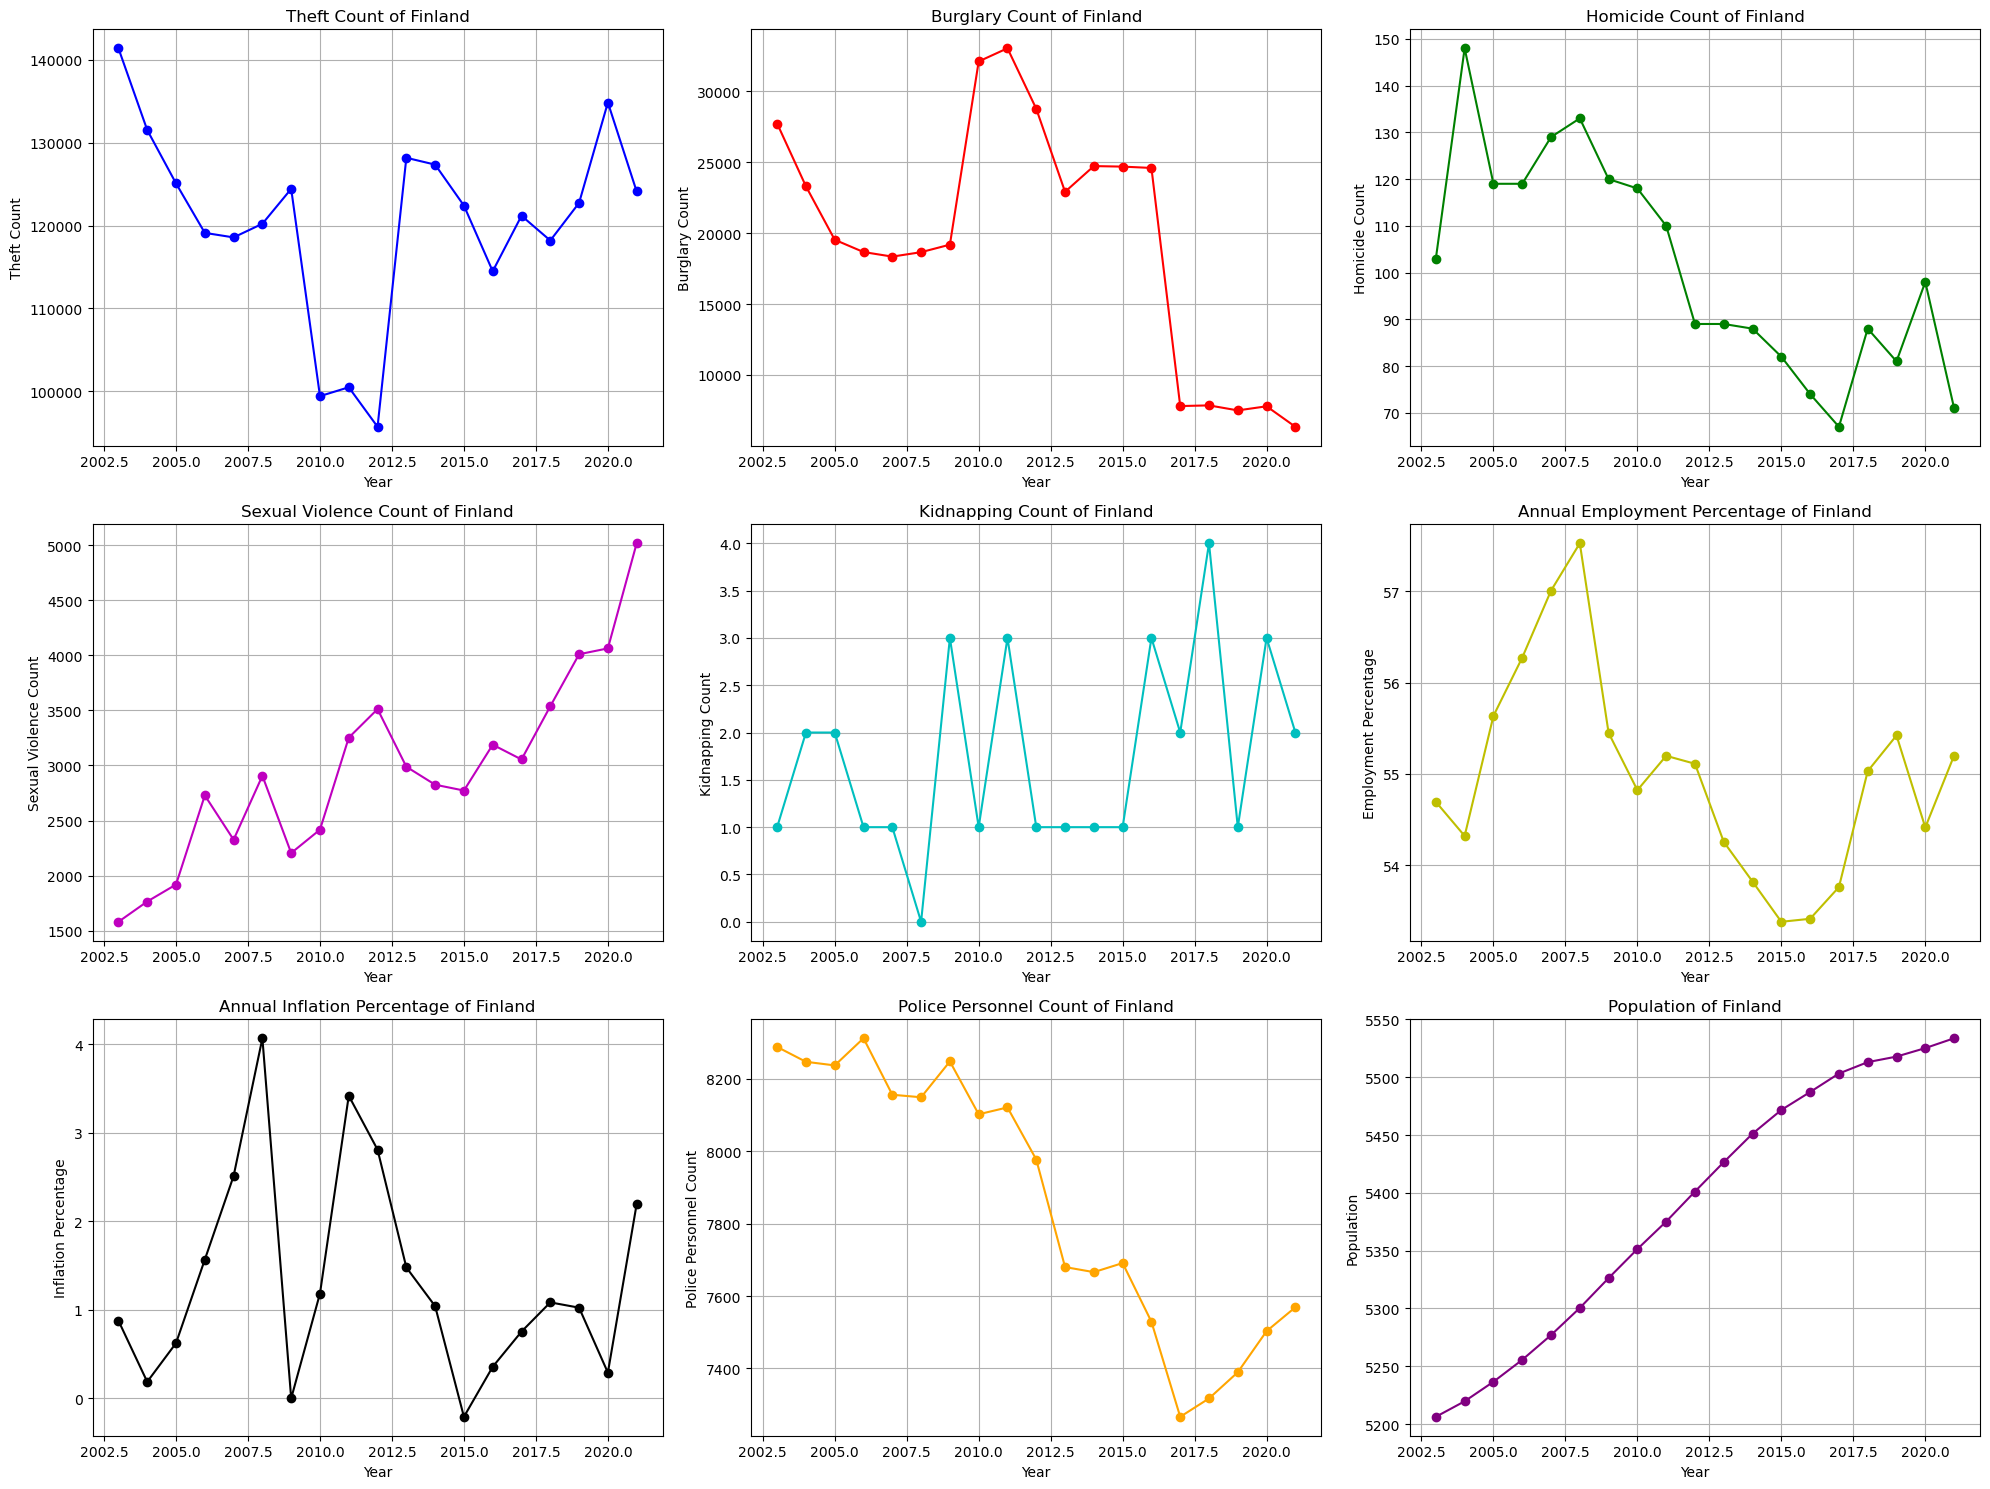

In [127]:
# Esegui la funzione per mostrare i dati di un paese specifico
show_data_of_country(data, 'Finland')

Adesso utilizziamo la funzione `show_global_data(data)`, dove `data` è il nostro dataset finale, per rappresentere i dati su scala globale.
Rappresentiamo graficamente l'andamento generale dei dati in tutto il mondo (basandoci sui paesi presenti nel nostro dataset).

In [128]:
def show_global_data(data):
    # Aggrega i dati per anno
    global_data = data.groupby('Year').sum().reset_index()

    # Estrai i dati aggregati per le diverse caratteristiche
    years = global_data['Year']
    theft = global_data['theft_count']
    burglary = global_data['burglary_count']
    homicide = global_data['homicide_count']
    sexual_violence = global_data['sexual_violence_count']
    kidnapping = global_data['kidnapping_count']
    employment = global_data['Annual_Employment_Perc']
    inflation = global_data['Annual_Inflation_Perc']
    police_personnel = global_data['police_personnel_count']
    population = global_data['Population']

    # Crea una figura e assi con 3x3 subplots (l'ultimo subplot sarà vuoto)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

    # Primo subplot: Theft
    axes[0, 0].plot(years, theft, marker='o', linestyle='-', color='b')
    axes[0, 0].set_title("Global Theft Count")
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Theft Count')
    axes[0, 0].grid(True)

    # Secondo subplot: Burglary
    axes[0, 1].plot(years, burglary, marker='o', linestyle='-', color='r')
    axes[0, 1].set_title("Global Burglary Count")
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Burglary Count')
    axes[0, 1].grid(True)

    # Terzo subplot: Homicide
    axes[0, 2].plot(years, homicide, marker='o', linestyle='-', color='g')
    axes[0, 2].set_title("Global Homicide Count")
    axes[0, 2].set_xlabel('Year')
    axes[0, 2].set_ylabel('Homicide Count')
    axes[0, 2].grid(True)

    # Quarto subplot: Sexual Violence
    axes[1, 0].plot(years, sexual_violence, marker='o', linestyle='-', color='m')
    axes[1, 0].set_title("Global Sexual Violence Count")
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Sexual Violence Count')
    axes[1, 0].grid(True)

    # Quinto subplot: Kidnapping
    axes[1, 1].plot(years, kidnapping, marker='o', linestyle='-', color='c')
    axes[1, 1].set_title("Global Kidnapping Count")
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Kidnapping Count')
    axes[1, 1].grid(True)

    # Sesto subplot: Employment
    axes[1, 2].plot(years, employment, marker='o', linestyle='-', color='y')
    axes[1, 2].set_title("Global Annual Employment Percentage")
    axes[1, 2].set_xlabel('Year')
    axes[1, 2].set_ylabel('Employment Percentage')
    axes[1, 2].grid(True)

    # Settimo subplot: Inflation
    axes[2, 0].plot(years, inflation, marker='o', linestyle='-', color='k')
    axes[2, 0].set_title("Global Annual Inflation Percentage")
    axes[2, 0].set_xlabel('Year')
    axes[2, 0].set_ylabel('Inflation Percentage')
    axes[2, 0].grid(True)

    # Ottavo subplot: Police Personnel
    axes[2, 1].plot(years, police_personnel, marker='o', linestyle='-', color='orange')
    axes[2, 1].set_title("Global Police Personnel Count")
    axes[2, 1].set_xlabel('Year')
    axes[2, 1].set_ylabel('Police Personnel Count')
    axes[2, 1].grid(True)

    # Nono subplot: Population
    axes[2, 2].plot(years, population, marker='o', linestyle='-', color='purple')
    axes[2, 2].set_title("Global Population")
    axes[2, 2].set_xlabel('Year')
    axes[2, 2].set_ylabel('Population')
    axes[2, 2].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

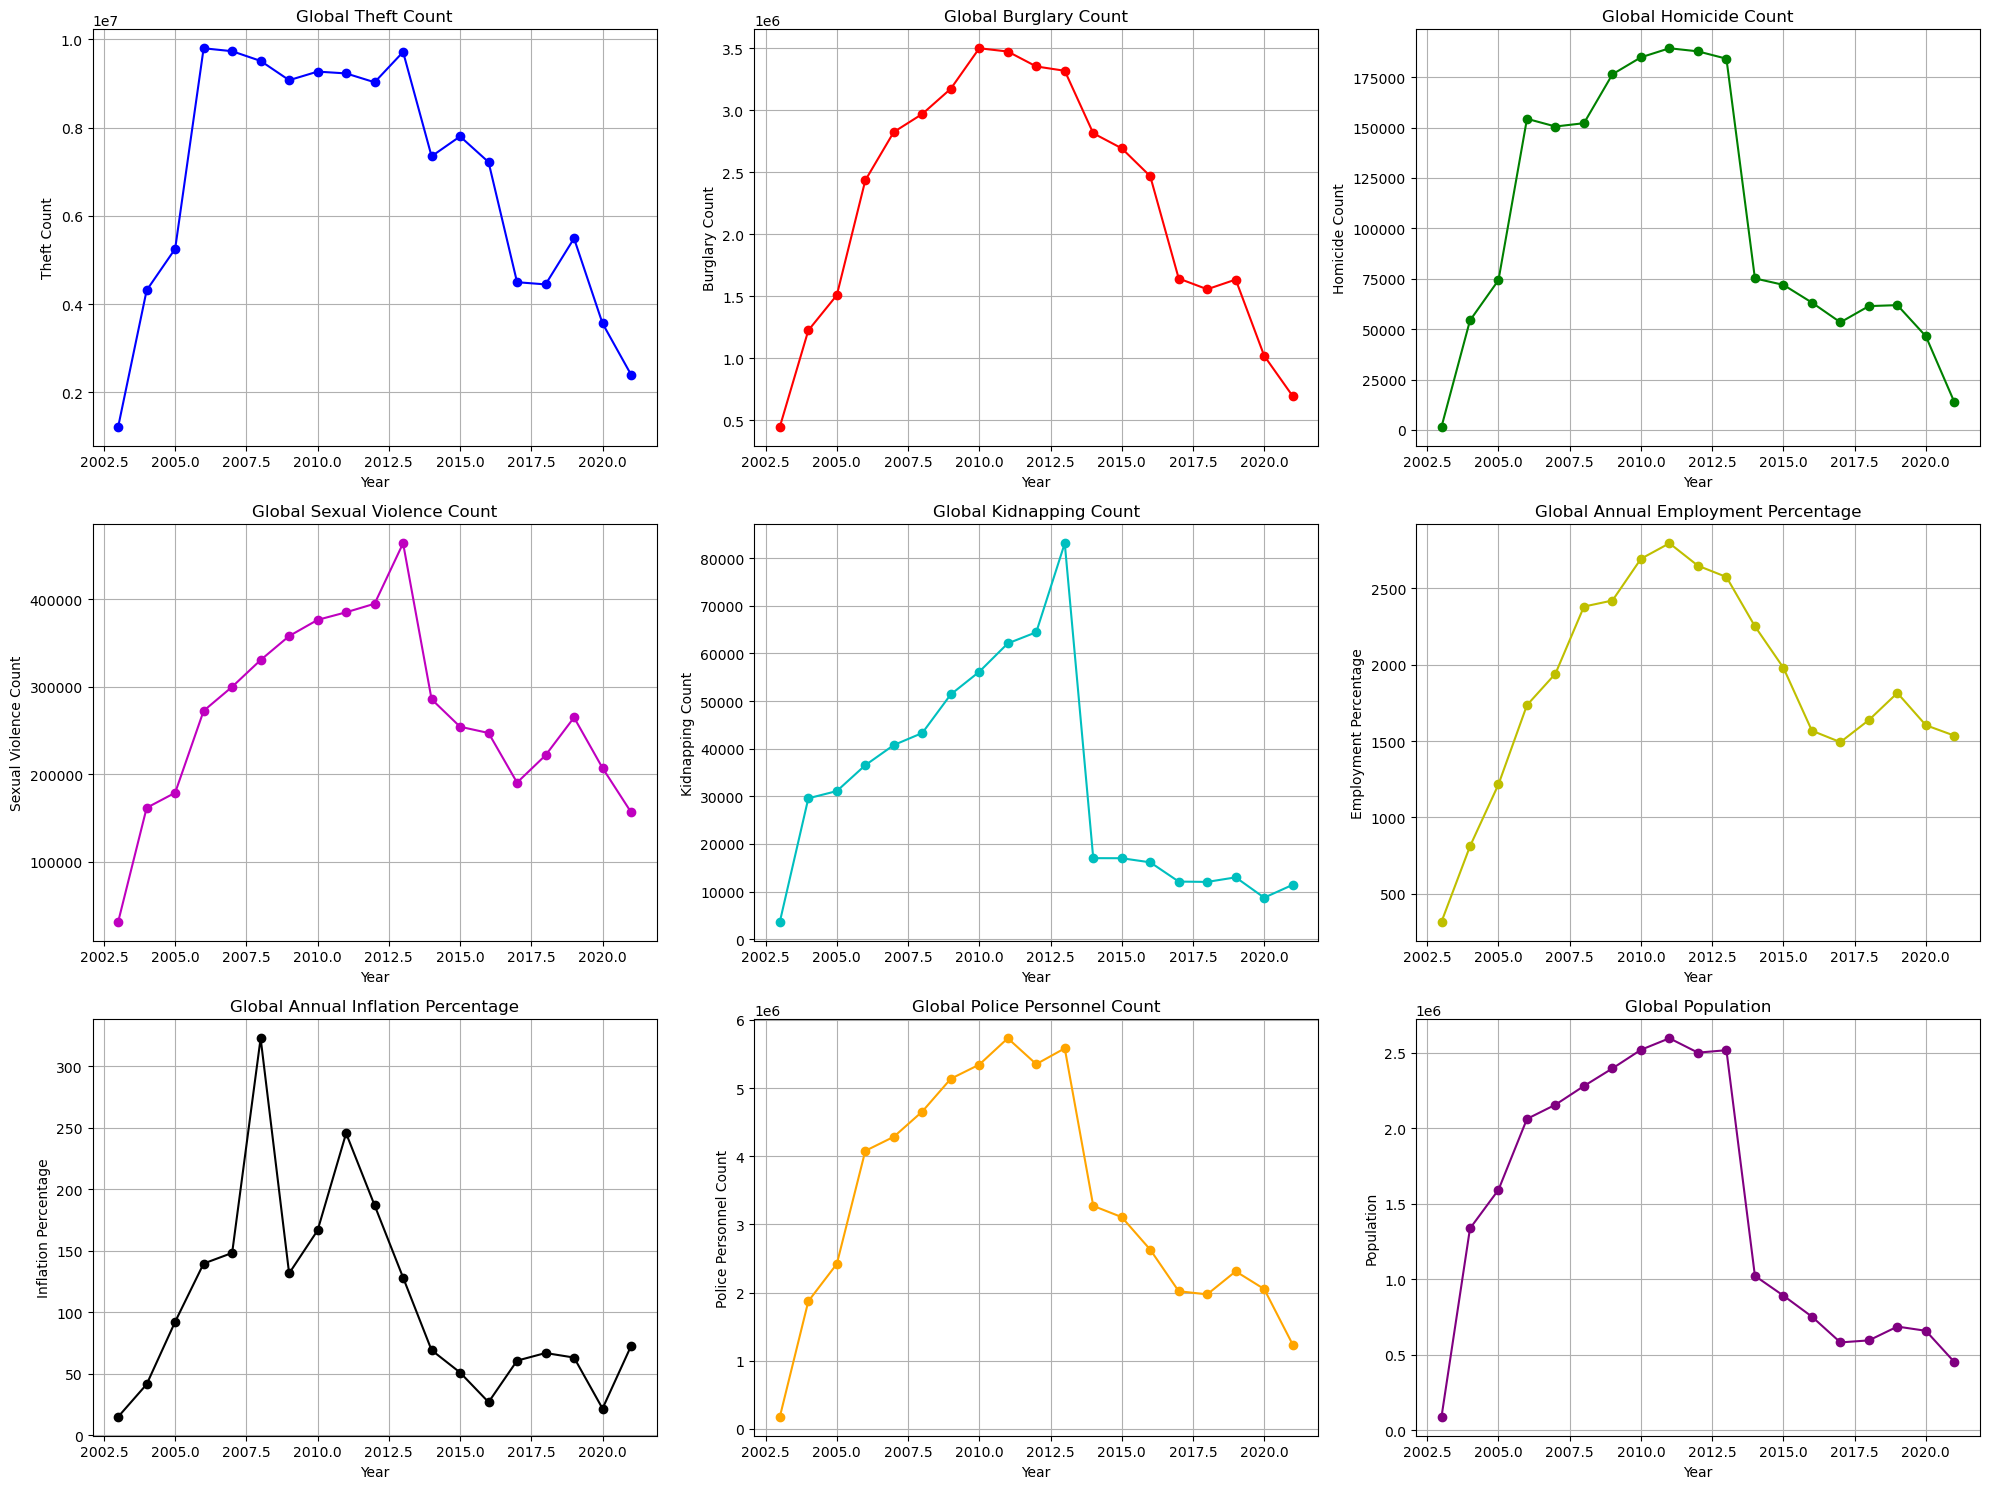

In [129]:
# Esegui la funzione per mostrare i dati globali
show_global_data(data)

### Analisi esplorativa

Analizziamo adesso i dati che abbiamo nel nostro dataset finale, considerando la correlazione tra loro attraverso la **Matrice di correlazione**.

Text(0.5, 1.0, 'Correlation')

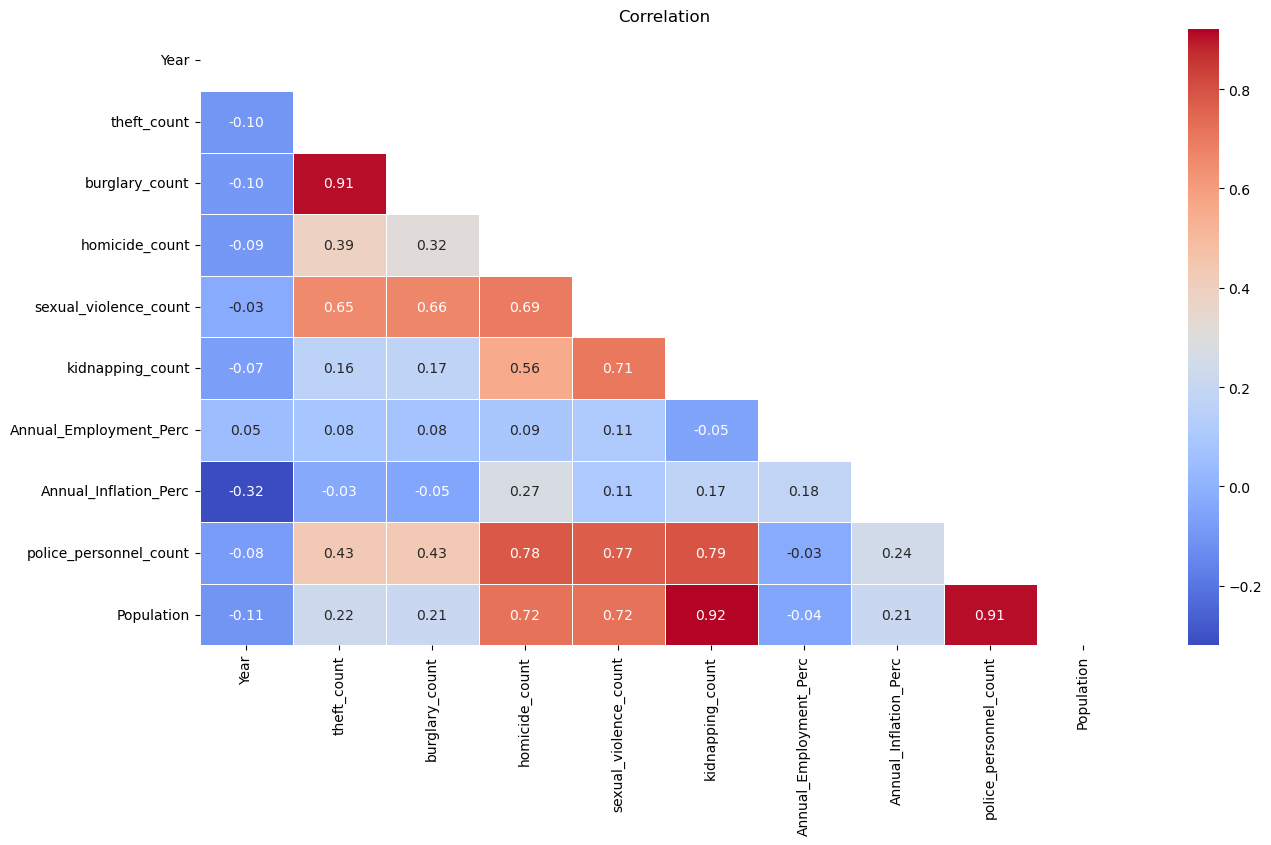

In [130]:
import seaborn as sns

corr_matrix = data[['Year', 'theft_count',	'burglary_count',	'homicide_count',	'sexual_violence_count',	'kidnapping_count',	'Annual_Employment_Perc',	'Annual_Inflation_Perc',	'police_personnel_count','Population']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', linewidths=0.5, fmt=".2f", ax=ax)
ax.set_title('Correlation')

Per poter avere una visualizzazione migliore di seguito andiamo a stampare i parametri di correlazione per ognuno dei crimini di nostro interesse.

In [131]:
# colonna di interesse: theft_count
abs(data[['Year', 'burglary_count', 'homicide_count', 'sexual_violence_count', 'kidnapping_count', 'Annual_Employment_Perc', 'Annual_Inflation_Perc', 'police_personnel_count', 'Population']]
    .corrwith(data['theft_count'])).sort_values(ascending=False)

burglary_count            0.908624
sexual_violence_count     0.654222
police_personnel_count    0.434182
homicide_count            0.386075
Population                0.224777
kidnapping_count          0.160223
Year                      0.097321
Annual_Employment_Perc    0.082797
Annual_Inflation_Perc     0.030067
dtype: float64

In [132]:
# colonna di interesse: burglary_count
abs(data[['Year', 'theft_count', 'homicide_count', 'sexual_violence_count', 'kidnapping_count', 'Annual_Employment_Perc', 'Annual_Inflation_Perc', 'police_personnel_count', 'Population']]
    .corrwith(data['burglary_count'])).sort_values(ascending=False)

theft_count               0.908624
sexual_violence_count     0.664437
police_personnel_count    0.431058
homicide_count            0.317509
Population                0.211220
kidnapping_count          0.172547
Year                      0.095281
Annual_Employment_Perc    0.076003
Annual_Inflation_Perc     0.046646
dtype: float64

In [133]:
# colonna di interesse: homicide_count
abs(data[['Year', 'theft_count', 'burglary_count', 'sexual_violence_count', 'kidnapping_count', 'Annual_Employment_Perc', 'Annual_Inflation_Perc', 'police_personnel_count', 'Population']]
    .corrwith(data['homicide_count'])).sort_values(ascending=False)

police_personnel_count    0.782583
Population                0.717017
sexual_violence_count     0.693969
kidnapping_count          0.555699
theft_count               0.386075
burglary_count            0.317509
Annual_Inflation_Perc     0.271579
Year                      0.094733
Annual_Employment_Perc    0.087000
dtype: float64

In [134]:
# colonna di interesse: sexual_violence_count
abs(data[['Year', 'theft_count', 'burglary_count', 'homicide_count', 'kidnapping_count', 'Annual_Employment_Perc', 'Annual_Inflation_Perc', 'police_personnel_count', 'Population']]
    .corrwith(data['sexual_violence_count'])).sort_values(ascending=False)

police_personnel_count    0.769764
Population                0.720814
kidnapping_count          0.706381
homicide_count            0.693969
burglary_count            0.664437
theft_count               0.654222
Annual_Employment_Perc    0.108493
Annual_Inflation_Perc     0.105282
Year                      0.028558
dtype: float64

In [135]:
# colonna di interesse: kidnapping_count
abs(data[['Year', 'theft_count', 'burglary_count', 'homicide_count', 'sexual_violence_count', 'Annual_Employment_Perc', 'Annual_Inflation_Perc', 'police_personnel_count', 'Population']]
    .corrwith(data['kidnapping_count'])).sort_values(ascending=False)

Population                0.920163
police_personnel_count    0.791530
sexual_violence_count     0.706381
homicide_count            0.555699
burglary_count            0.172547
Annual_Inflation_Perc     0.171205
theft_count               0.160223
Year                      0.068800
Annual_Employment_Perc    0.052741
dtype: float64

# Preparazione dei dati

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error

Eliminiamo la colonna `burglary` e `Population` in quanto abbiamo visto che la loro correlazione con i dati potrebbe essere problematica rendendo la regressione instabile. Inoltre ha senso che con l'aumentare della popolazione molti crimini di conseguenza aumentino, quindi non riteniamo sia di cruciale importantza il mantenimento di quest'ultima.

In [137]:
data = data.drop(['burglary_count', 'Population'], axis=1)

Effettuiamo una trasformazione delle variabili percentuali in decimali:

In [138]:
data['Annual_Employment_Perc'] = data['Annual_Employment_Perc'] / 100.0
data['Annual_Inflation_Perc'] = data['Annual_Inflation_Perc'] / 100.0

Osserviamo ora i dati per paese e valutiamo quali nazioni eliminare in base al numero di istanze che presentano. Facciamo ciò poiché la presenza di poche istanze potrebbe causare problemi durante il traning del modello.

In [139]:
area_counts = data['Country'].value_counts().reset_index(name='Count')
area_counts.sort_values(by='Count')

,index,Count
64,Cabo Verde,1
60,Paraguay,2
63,Ecuador,2
62,Thailand,2
61,Bosnia and Herzegovina,2
...,...,...
4,Germany,18
3,Cyprus,18
2,Canada,18
1,Slovenia,19


In [140]:
area_counts[area_counts['Count'] < 6]

,index,Count
48,Honduras,5
49,Guyana,5
50,Jamaica,5
51,Belize,4
52,Mongolia,4
53,Kazakhstan,4
54,Italy,4
55,North Macedonia,4
56,Bhutan,3
57,Dominican Republic,3


In [141]:
countries_to_remove = ['Honduras', 'Guyana', 'Jamaica', 'Belize', 'Mongolia',
                       'Kazakhstan', 'Italy', 'North Macedonia', 'Bhutan',
                       'Dominican Republic', 'Myanmar', 'Mauritius', 'Paraguay',
                       'Bosnia and Herzegovina', 'Thailand', 'Ecuador', 'Cabo Verde']

data = data[~data['Country'].isin(countries_to_remove)]

Estraiamo dal frame:

*  le varie serie `y` con i valori delle variabili `theft_count`, `homicide_count`, `sexual_violence_count` e `kidnapping_count` da prevedere
*  il frame X con i valori di tutte le altre variabili, utilizzabili per la predizione

Poiché i valori di `theft_count`, `homicide_count`, `sexual_violence_count` e `kidnapping_count` variano su un ampi range decidiamo di attuare una trasformazione logaritmica, la quale può stabilizzare la varianza e migliorare le prestazioni del modello.

In [142]:
X = data.drop(columns=['theft_count', 'homicide_count', 'sexual_violence_count', 'kidnapping_count'])

In [143]:
y_theft = np.log1p(data['theft_count'])
y_homicide = np.log1p(data['homicide_count'])
y_sexual_violence = np.log1p(data['sexual_violence_count'])
y_kidnapping = np.log1p(data['kidnapping_count'])

Dividiamo i dati tra test e traning:

In [144]:
X_train, X_test, y_theft_train, y_theft_test = train_test_split(X, y_theft, test_size=0.2, random_state=42)
y_homicide_train, y_homicide_test = train_test_split(y_homicide, test_size=0.2, random_state=42)
y_sexual_violence_train, y_sexual_violence_test = train_test_split(y_sexual_violence, test_size=0.2, random_state=42)
y_kidnapping_train, y_kidnapping_test = train_test_split(y_kidnapping, test_size=0.2, random_state=42)

Effettuiamo il preprocessing delle colonne del nostro dataset:

In [145]:
# Preprocessing delle colonne
numeric_features = ['Annual_Employment_Perc', 'Annual_Inflation_Perc', 'police_personnel_count']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(drop='first'), ['Country'])])


Funzione per addestrare e valutare i modelli

In [146]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

def train_and_evaluate_models(models, X_train, X_test, y_train, y_test, r2_array):
    for target, model in models.items():
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
        pipe.fit(X_train, y_train[target])
        y_pred = pipe.predict(X_test)

        mse = mean_squared_error(y_test[target], y_pred)
        r2 = r2_score(y_test[target], y_pred)
        mape = mean_absolute_percentage_error(np.expm1(y_test[target]), np.expm1(y_pred))

        r2_array.append(r2)

        print(f"Target: {target}")
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"R^2 Score: {r2}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape}")
        print("\n")

In [147]:
def train_and_evaluate_models_plot(models, X_train, X_test, y_train, y_test):
    for target, model in models.items():
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
        pipe.fit(X_train, y_train[target])
        y_pred = pipe.predict(X_test)

        plt.figure(figsize=(8, 4))
        plt.title(f"Actual vs Predicted '{target}' Count")
        sns.kdeplot(y_test[target], color="green", label="Actual", fill=True)
        sns.kdeplot(y_pred, color='red', label="Predicted", fill=True)
        plt.legend(title='Legend', loc='upper right', labels=['Actual Value', 'Predicted Value'])
        plt.xlabel(f"{target} Count")
        plt.ylabel("Density")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Modelli

### Lasso

Utilizziamo la LassoCV poiché è una forma avanzata di Lasso che automatizza il processo di selezione dell'iperparametro alpha, rendendo più semplice e efficiente il processo di addestramento e selezione del modello Lasso.

In [148]:
lasso_models = {
    'theft_count': LassoCV(cv=10, random_state=42),
    'homicide_count': LassoCV(cv=10, random_state=42),
    'sexual_violence_count': LassoCV(cv=10, random_state=42),
    'kidnapping_count': LassoCV(cv=10, random_state=42)
}

lasso_r2=[]


# Addestramento e valutazione dei modelli Lasso
print("Lasso Regression:\n")
train_and_evaluate_models(lasso_models, X_train, X_test, {
    'theft_count': y_theft_train,
    'homicide_count': y_homicide_train,
    'sexual_violence_count': y_sexual_violence_train,
    'kidnapping_count': y_kidnapping_train
}, {
    'theft_count': y_theft_test,
    'homicide_count': y_homicide_test,
    'sexual_violence_count': y_sexual_violence_test,
    'kidnapping_count': y_kidnapping_test
}, lasso_r2)

Lasso Regression:

Target: theft_count
Mean Squared Error (MSE): 0.16480783156033524
R^2 Score: 0.9568216391323656
Mean Absolute Percentage Error (MAPE): 0.288430849771833


Target: homicide_count
Mean Squared Error (MSE): 0.09139195842209617
R^2 Score: 0.9797823811235208
Mean Absolute Percentage Error (MAPE): 0.2704282785250976


Target: sexual_violence_count
Mean Squared Error (MSE): 0.3007753422495917
R^2 Score: 0.9165533690565638
Mean Absolute Percentage Error (MAPE): 0.3861818965509014


Target: kidnapping_count
Mean Squared Error (MSE): 0.258786646817271
R^2 Score: 0.9550430677137078
Mean Absolute Percentage Error (MAPE): 201102354886868.47




### Ridge

Analogamente a quanto avviene sopra andiamo ad utilizzare RidgeCV.

Scegliamo di utilizzare RidgeCV poiché automatizza la selezione del parametro di regolarizzazione (alpha) tramite cross-validation, fornendo una stima più robusta delle prestazioni del modello e prevenendo l'overfitting, senza richiedere ulteriori ricerche manuali degli iperparametri.








In [149]:
ridge_models = {
    'theft_count': RidgeCV(alphas=np.logspace(-4, 0, 100), cv=10),
    'homicide_count': RidgeCV(alphas=np.logspace(-4, 0, 100), cv=10),
    'sexual_violence_count': RidgeCV(alphas=np.logspace(-4, 0, 100), cv=10),
    'kidnapping_count': RidgeCV(alphas=np.logspace(-4, 0, 100), cv=10)
}

ridge_r2=[]

# Addestramento e valutazione dei modelli Ridge
print("Ridge Regression:\n")
train_and_evaluate_models(ridge_models, X_train, X_test, {
    'theft_count': y_theft_train,
    'homicide_count': y_homicide_train,
    'sexual_violence_count': y_sexual_violence_train,
    'kidnapping_count': y_kidnapping_train
}, {
    'theft_count': y_theft_test,
    'homicide_count': y_homicide_test,
    'sexual_violence_count': y_sexual_violence_test,
    'kidnapping_count': y_kidnapping_test
}, ridge_r2)

Ridge Regression:

Target: theft_count
Mean Squared Error (MSE): 0.13539104673773036
R^2 Score: 0.9645286063232481
Mean Absolute Percentage Error (MAPE): 0.23911342451131995


Target: homicide_count
Mean Squared Error (MSE): 0.0744819467134558
R^2 Score: 0.9835231935300469
Mean Absolute Percentage Error (MAPE): 0.23446013093672444


Target: sexual_violence_count
Mean Squared Error (MSE): 0.23636129034422326
R^2 Score: 0.9344243008181781
Mean Absolute Percentage Error (MAPE): 0.2725297473170543


Target: kidnapping_count
Mean Squared Error (MSE): 0.24068425965723678
R^2 Score: 0.9581878505059535
Mean Absolute Percentage Error (MAPE): 132320631020198.16




### Elastic Net

In [150]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

# Definizione degli alpha da testare
alphas = [0.001, 0.01, 0.1, 1.0]

# Modelli Elastic Net
elastic_net_models = {
    'theft_count': ElasticNetCV(alphas=alphas, cv=5),
    'homicide_count': ElasticNetCV(alphas=alphas, cv=5),
    'sexual_violence_count': ElasticNetCV(alphas=alphas, cv=5),
    'kidnapping_count': ElasticNetCV(alphas=alphas, cv=5)
}

elastic_net_r2=[]

# Addestramento e valutazione dei modelli Elastic Net
print("Elastic Net:\n")
train_and_evaluate_models(elastic_net_models, X_train, X_test, {
    'theft_count': y_theft_train,
    'homicide_count': y_homicide_train,
    'sexual_violence_count': y_sexual_violence_train,
    'kidnapping_count': y_kidnapping_train
}, {
    'theft_count': y_theft_test,
    'homicide_count': y_homicide_test,
    'sexual_violence_count': y_sexual_violence_test,
    'kidnapping_count': y_kidnapping_test
}, elastic_net_r2)

Elastic Net:

Target: theft_count
Mean Squared Error (MSE): 0.18185812654802194
R^2 Score: 0.9523545954069075
Mean Absolute Percentage Error (MAPE): 0.31210726432969976


Target: homicide_count
Mean Squared Error (MSE): 0.09603206114535477
R^2 Score: 0.9787559031923523
Mean Absolute Percentage Error (MAPE): 0.2773780911371547


Target: sexual_violence_count
Mean Squared Error (MSE): 0.31106494100499316
R^2 Score: 0.9136986391991357
Mean Absolute Percentage Error (MAPE): 0.39982956403332115


Target: kidnapping_count
Mean Squared Error (MSE): 0.2745869963859816
R^2 Score: 0.9522981994819175
Mean Absolute Percentage Error (MAPE): 223900678138009.75




### Decision Tree

In [151]:
from sklearn.tree import DecisionTreeRegressor

# Modelli Decision Tree
decision_tree_models = {
    'theft_count': DecisionTreeRegressor(),
    'homicide_count': DecisionTreeRegressor(),
    'sexual_violence_count': DecisionTreeRegressor(),
    'kidnapping_count': DecisionTreeRegressor()
}

decision_tree_r2=[]

# Addestramento e valutazione dei modelli Decision Tree
print("Decision Tree:\n")
train_and_evaluate_models(decision_tree_models, X_train, X_test, {
    'theft_count': y_theft_train,
    'homicide_count': y_homicide_train,
    'sexual_violence_count': y_sexual_violence_train,
    'kidnapping_count': y_kidnapping_train
}, {
    'theft_count': y_theft_test,
    'homicide_count': y_homicide_test,
    'sexual_violence_count': y_sexual_violence_test,
    'kidnapping_count': y_kidnapping_test
}, decision_tree_r2)

Decision Tree:

Target: theft_count
Mean Squared Error (MSE): 0.23319423672086154
R^2 Score: 0.9389049366765091
Mean Absolute Percentage Error (MAPE): 0.26865276494482065


Target: homicide_count
Mean Squared Error (MSE): 0.20565480710090137
R^2 Score: 0.9545052914734715
Mean Absolute Percentage Error (MAPE): 0.39391249499377273


Target: sexual_violence_count
Mean Squared Error (MSE): 0.3018831938175436
R^2 Score: 0.9162460084855822
Mean Absolute Percentage Error (MAPE): 0.40783550899025184


Target: kidnapping_count
Mean Squared Error (MSE): 0.6839852801449565
R^2 Score: 0.8811767133177864
Mean Absolute Percentage Error (MAPE): 381660985370381.8




### Random Forest

In [152]:
from sklearn.ensemble import RandomForestRegressor

# Modelli Random Forest
random_forest_models = {
    'theft_count': RandomForestRegressor(),
    'homicide_count': RandomForestRegressor(),
    'sexual_violence_count': RandomForestRegressor(),
    'kidnapping_count': RandomForestRegressor()
}

random_forest_r2=[]

# Addestramento e valutazione dei modelli Random Forest
print("Random Forest:\n")
train_and_evaluate_models(random_forest_models, X_train, X_test, {
    'theft_count': y_theft_train,
    'homicide_count': y_homicide_train,
    'sexual_violence_count': y_sexual_violence_train,
    'kidnapping_count': y_kidnapping_train
}, {
    'theft_count': y_theft_test,
    'homicide_count': y_homicide_test,
    'sexual_violence_count': y_sexual_violence_test,
    'kidnapping_count': y_kidnapping_test
}, random_forest_r2)

Random Forest:

Target: theft_count
Mean Squared Error (MSE): 0.08952867264597617
R^2 Score: 0.9765441890782172
Mean Absolute Percentage Error (MAPE): 0.23549328980596032


Target: homicide_count
Mean Squared Error (MSE): 0.24352350034219158
R^2 Score: 0.946128024802298
Mean Absolute Percentage Error (MAPE): 0.4007076638471042


Target: sexual_violence_count
Mean Squared Error (MSE): 0.15629410749815362
R^2 Score: 0.9566380122469967
Mean Absolute Percentage Error (MAPE): 0.26691765908358306


Target: kidnapping_count
Mean Squared Error (MSE): 0.39044562733512134
R^2 Score: 0.9321710070999983
Mean Absolute Percentage Error (MAPE): 670517589374504.1




### Funzioni Kernel

In [153]:
from sklearn.kernel_ridge import KernelRidge

# Modelli Kernel Ridge
kernel_ridge_models = {
    'theft_count': KernelRidge(kernel='rbf'),
    'homicide_count': KernelRidge(kernel='rbf'),
    'sexual_violence_count': KernelRidge(kernel='rbf'),
    'kidnapping_count': KernelRidge(kernel='rbf')
}

kernel_ridge_r2=[]

# Addestramento e valutazione dei modelli Kernel Ridge
print("Kernel Ridge:\n")
train_and_evaluate_models(kernel_ridge_models, X_train, X_test, {
    'theft_count': y_theft_train,
    'homicide_count': y_homicide_train,
    'sexual_violence_count': y_sexual_violence_train,
    'kidnapping_count': y_kidnapping_train
}, {
    'theft_count': y_theft_test,
    'homicide_count': y_homicide_test,
    'sexual_violence_count': y_sexual_violence_test,
    'kidnapping_count': y_kidnapping_test
}, kernel_ridge_r2)

Kernel Ridge:

Target: theft_count
Mean Squared Error (MSE): 1.2298797869080862
R^2 Score: 0.6777811299368657
Mean Absolute Percentage Error (MAPE): 1.4833361843176711


Target: homicide_count
Mean Squared Error (MSE): 1.6180453014433016
R^2 Score: 0.6420579688382142
Mean Absolute Percentage Error (MAPE): 2.116301153366011


Target: sexual_violence_count
Mean Squared Error (MSE): 1.1517629219757983
R^2 Score: 0.6804567330366702
Mean Absolute Percentage Error (MAPE): 1.3249838278321668


Target: kidnapping_count
Mean Squared Error (MSE): 2.4344106182870138
R^2 Score: 0.5770893333586957
Mean Absolute Percentage Error (MAPE): 4548242261584921.0




### Regressione Lineare

In [154]:
from sklearn.linear_model import LinearRegression

linear_regression_models = {
    'theft_count': LinearRegression(),
    'homicide_count': LinearRegression(),
    'sexual_violence_count': LinearRegression(),
    'kidnapping_count': LinearRegression()
}

linear_regr_r2 = []

print("Linear Regression:\n")
linear_regression_r2 = train_and_evaluate_models(linear_regression_models, X_train, X_test, {
    'theft_count': y_theft_train,
    'homicide_count': y_homicide_train,
    'sexual_violence_count': y_sexual_violence_train,
    'kidnapping_count': y_kidnapping_train
}, {
    'theft_count': y_theft_test,
    'homicide_count': y_homicide_test,
    'sexual_violence_count': y_sexual_violence_test,
    'kidnapping_count': y_kidnapping_test
}, linear_regr_r2)

Linear Regression:

Target: theft_count
Mean Squared Error (MSE): 0.13596628420046175
R^2 Score: 0.9643778986140619
Mean Absolute Percentage Error (MAPE): 0.23922237218777556


Target: homicide_count
Mean Squared Error (MSE): 0.07661296586075218
R^2 Score: 0.9830517720430542
Mean Absolute Percentage Error (MAPE): 0.23771286824402885


Target: sexual_violence_count
Mean Squared Error (MSE): 0.23440018535475332
R^2 Score: 0.93496838665671
Mean Absolute Percentage Error (MAPE): 0.27178217316212655


Target: kidnapping_count
Mean Squared Error (MSE): 0.24393692223172989
R^2 Score: 0.9576227914779469
Mean Absolute Percentage Error (MAPE): 134185543494868.06




### Extreme Gradient Boosting

In [155]:
!pip install xgboost

In [157]:
from xgboost import XGBRegressor

xgb_models = {
    'theft_count': XGBRegressor(objective='reg:squarederror', random_state=42),
    'homicide_count': XGBRegressor(objective='reg:squarederror', random_state=42),
    'sexual_violence_count': XGBRegressor(objective='reg:squarederror', random_state=42),
    'kidnapping_count': XGBRegressor(objective='reg:squarederror', random_state=42)
}

print("XGBoost Regression:\n")
xgb_r2 = []
train_and_evaluate_models(xgb_models, X_train, X_test, {
    'theft_count': y_theft_train,
    'homicide_count': y_homicide_train,
    'sexual_violence_count': y_sexual_violence_train,
    'kidnapping_count': y_kidnapping_train
}, {
    'theft_count': y_theft_test,
    'homicide_count': y_homicide_test,
    'sexual_violence_count': y_sexual_violence_test,
    'kidnapping_count': y_kidnapping_test
}, xgb_r2)

XGBoost Regression:

Target: theft_count
Mean Squared Error (MSE): 0.12563139605916832
R^2 Score: 0.9670855583500498
Mean Absolute Percentage Error (MAPE): 0.21725272536201257


Target: homicide_count
Mean Squared Error (MSE): 0.2795407249144524
R^2 Score: 0.9381603377982904
Mean Absolute Percentage Error (MAPE): 0.3212871136818209


Target: sexual_violence_count
Mean Squared Error (MSE): 0.14003051964322433
R^2 Score: 0.9611501561062504
Mean Absolute Percentage Error (MAPE): 0.315655662063177


Target: kidnapping_count
Mean Squared Error (MSE): 0.30194720181845025
R^2 Score: 0.9475451300399882
Mean Absolute Percentage Error (MAPE): 162800676776804.22




### Valutazione dei modelli migliori

Dai dati ottuenuti possiamo fare una classificazione dei modelli migliori per la predizione di ogni crimine che abbiamo preso in esame.

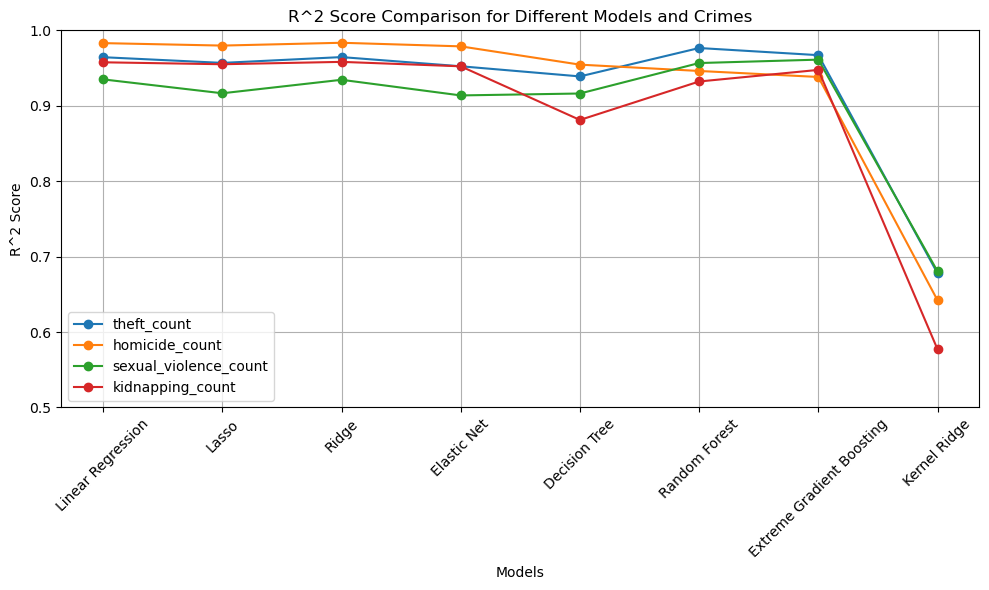

In [158]:
models = ['Linear Regression', 'Lasso', 'Ridge', 'Elastic Net', 'Decision Tree', 'Random Forest', 'Extreme Gradient Boosting', 'Kernel Ridge']
targets = ['theft_count', 'homicide_count', 'sexual_violence_count', 'kidnapping_count']

plt.figure(figsize=(10, 6))

for i, target in enumerate(targets):
    plt.plot(models, [linear_regr_r2[i], lasso_r2[i], ridge_r2[i], elastic_net_r2[i], decision_tree_r2[i], random_forest_r2[i], xgb_r2[i], kernel_ridge_r2[i]], marker='o', label=target)

plt.title('R^2 Score Comparison for Different Models and Crimes')
plt.xlabel('Models')
plt.ylabel('R^2 Score')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [159]:
max_r2_values = []
for i, target in enumerate(targets):
    r2_values = [linear_regr_r2[i], lasso_r2[i], ridge_r2[i], elastic_net_r2[i], decision_tree_r2[i], random_forest_r2[i], xgb_r2[i], kernel_ridge_r2[i]]
    max_r2 = max(r2_values)
    max_index = r2_values.index(max_r2)
    best_model = models[max_index]
    max_r2_values.append((max_r2, best_model))

# Stampare i risultati
for i, target in enumerate(targets):
    max_r2, best_model = max_r2_values[i]
    print(f"For target '{target}':")
    print(f"   - Maximum R^2: {max_r2:.2f}")
    print(f"   - Best model: {best_model}")
    print()

For target 'theft_count':
   - Maximum R^2: 0.98
   - Best model: Random Forest

For target 'homicide_count':
   - Maximum R^2: 0.98
   - Best model: Ridge

For target 'sexual_violence_count':
   - Maximum R^2: 0.96
   - Best model: Extreme Gradient Boosting

For target 'kidnapping_count':
   - Maximum R^2: 0.96
   - Best model: Ridge



Infine, attraverso la funzione prima definita `train_and_evaluate_models_plot`, possiamo ottenere e analizzare graficamente l'accuratezza dei dati predetti dalle varie regressioni, confrontandoli con i dati di validazione.

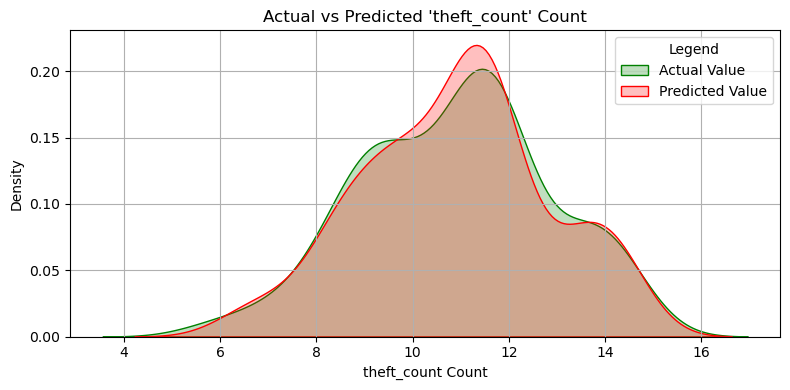

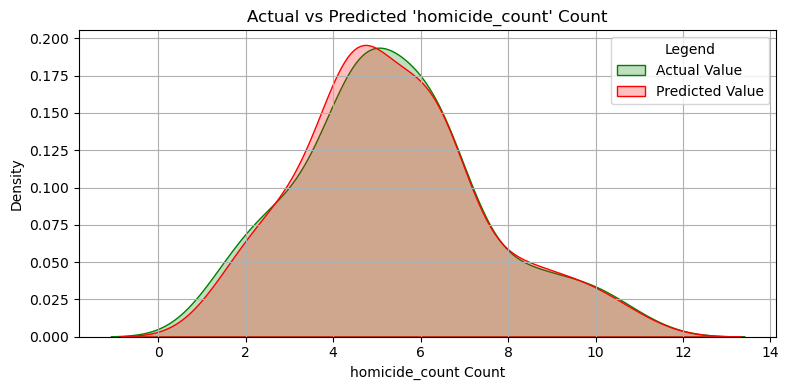

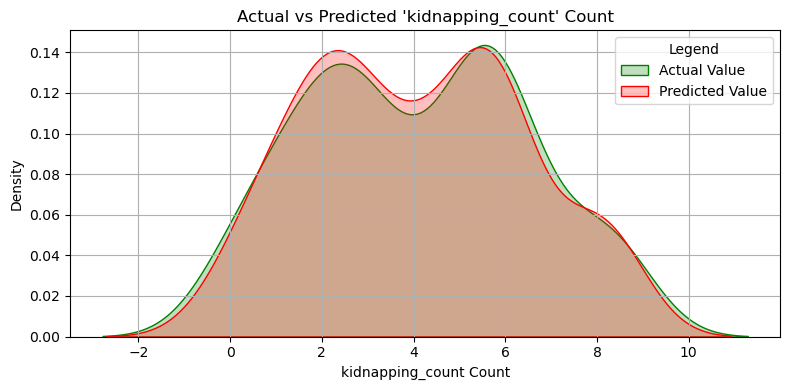

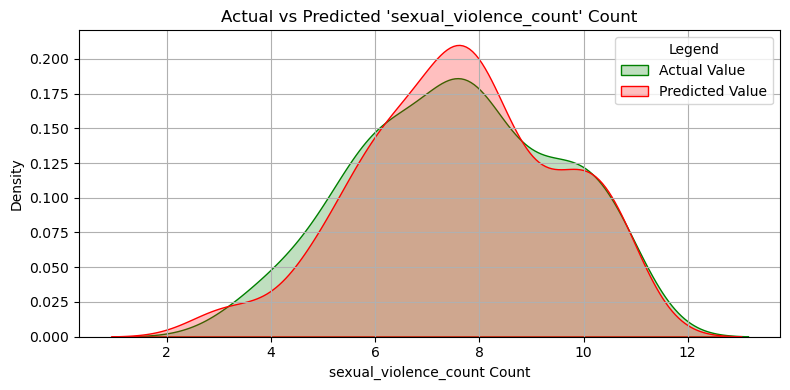

In [160]:
ridge_models = {
    'homicide_count': RidgeCV(alphas=np.logspace(-4, 0, 100), cv=10),
    'kidnapping_count': RidgeCV(alphas=np.logspace(-4, 0, 100), cv=10)
}

random_forest_models = {
    'theft_count': RandomForestRegressor()
}


xgb_models = {
    'sexual_violence_count': XGBRegressor(objective='reg:squarederror', random_state=42)
}


train_and_evaluate_models_plot(random_forest_models, X_train, X_test, {
    'theft_count': y_theft_train
}, {
    'theft_count': y_theft_test
})


train_and_evaluate_models_plot(ridge_models, X_train, X_test, {
    'homicide_count': y_homicide_train,
    'kidnapping_count': y_kidnapping_train
}, {
    'homicide_count': y_homicide_test,
    'kidnapping_count': y_kidnapping_test
})


train_and_evaluate_models_plot(xgb_models, X_train, X_test, {
    'sexual_violence_count': y_sexual_violence_train
}, {
    'sexual_violence_count': y_sexual_violence_test
})

# Conclusioni

Osservando i risultati e il grafico sopra riportati, arriviamo alla conclusione che i modelli migliori per la predizione dei vari crimini sono:
*  **`Theft`**: *Regressione Random Forest*
*  **`Homicide`**: *Regressione Ridge*
*  **`Sexual Violence`**: *Extreme Gradient Boosting*
*  **`Kidnapping`**: *Regressione Ridge*

Possiamo inoltre concludere, analizzando i valori delle metriche, che il modello ha una buona capacità predittiva, con un errore sempre abbastanza contenuto.

Il valore del **_coefficiente di determinazione_ $R^2$** vicino a 1 inddica infatti che il modello si adatta bene ai dati osservati.